In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False


The path is: /home/ucecabj/Desktop/pyMFI_git


In [5]:
def MFI_2D(HILLS="HILLS", position_x="position_x", position_y="position_y", bw = np.array((0.1,0.1)), kT=1,
			min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)),
			error_pace=-1, base_terms = 0, window_corners=[], WellTempered=1, nhills=-1, periodic = np.array((0,0)), 
			Ftot_den_limit = 1E-10, FES_cutoff = -1, Ftot_den_cutoff = 0.1, non_exploration_pentaly=-1, use_weighted_st_dev = True,
			hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
			lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
			uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0, ref_fes = np.zeros((200,200))):
	"""Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 2D CV spaces.

	Args:
		HILLS (str): HILLS array. Defaults to "HILLS".
		position_x (str): CV1 array. Defaults to "position_x".
		position_y (str): CV2 array. Defaults to "position_y".
		bw (int, optional): Scalar, bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
		kT (int, optional): Scalar, kT. Defaults to 1.
		min_grid (array, optional): Lower bound of the force domain. Defaults to np.array((-np.pi, -np.pi)).
		max_grid (array, optional): Upper bound of the force domain. Defaults to np.array((np.pi, np.pi)).
		nbins (array, optional): number of bins in CV2,CV1. First enrty is the number of bins in CV2 and the second entry is the number of bins in CV1! Defaults to np.array((200,200)). 
		error_pace (int, optional): Pace for the calculation of the on-the-fly measure of global convergence. Defaults to 1, change it to a higher value if FES_cutoff>0 is used. 
		base_terms (int or list, optional): When set to 0, inactive. When activated, "on the fly" variance is calculated as a patch to base (previous) simulation. To activate, put force terms of base simulation ([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]). Defaults to 0.
		window_corners (list, optional): When set to [], inactive. When activated, error is ALSO calculated for mean force in the window. To activate, put the min and max values of the window ([min_x, max_x, min_y, max_y]). Defaults to [].
		WellTempered (binary, optional): Is the simulation well tempered? . Defaults to 1.
		nhills (int, optional): Number of HILLS to analyse, -1 for the entire HILLS array. Defaults to -1, i.e. the entire dataset.
		periodic (int, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
		Ftot_den_limit (float, optional): Truncation of the probability density for numerical reasons, to avaiod devisions by zero (or suare root of negative numbers). If the probability density (Ftot_den) of some CV region is lover than the Ftot_den_limit, it will be set to zero. Default is set to 1E-10.
		FES_cutoff (float, optional): Cutoff applied to error calculation for FES values over the FES_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0. When FES_cutoff <= 0, no cufoff is applied. Use with care, computing the fes in the loop renders the calculation slow.
		Ftot_den_cutoff (float, optional): Cutoff applied to error calculation for probability density (Ftot_den) values below the Ftot_den_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0.1. When Ftot_den_cutoff <= 0, no cufoff is applied. 
		non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
		hp_centre_x (float, optional): CV1-position of harmonic potential. Defaults to 0.0.
		hp_centre_y (float, optional): CV2-position of harmonic potential. Defaults to 0.0.
		hp_kappa_x (int, optional): CV1-force_constant of harmonic potential. Defaults to 0.
		hp_kappa_y (int, optional): CV2-force_constant of harmonic potential. Defaults to 0.
		lw_centre_x (float, optional): CV1-position of lower wall potential. Defaults to 0.0.
		lw_centre_y (float, optional): CV2-position of lower wall potential. Defaults to 0.0.
		lw_kappa_x (int, optional): CV1-force_constant of lower wall potential. Defaults to 0.
		lw_kappa_y (int, optional): CV2-force_constant of lower wall potential. Defaults to 0.
		uw_centre_x (float, optional): CV1-position of upper wall potential. Defaults to 0.0.
		uw_centre_y (float, optional): CV2-position of upper wall potential. Defaults to 0.0.
		uw_kappa_x (int, optional): CV1-force_constant of upper wall potential. Defaults to 0.
		uw_kappa_y (int, optional): CV2-force_constant of upper wall potential. Defaults to 0.

	Returns:
		X: array of size (nbins[0], nbins[1]) - CV1 grid positions
		Y: array of size (nbins[0], nbins[1]) - CV2 grid positions
		Ftot_den: array of size (nbins[0], nbins[1]) - Cumulative biased probability density, equivalent to an unbiased histogram of samples in CV space.
		Ftot_x:  array of size (nbins[0], nbins[1]) - CV1 component of the Mean Force.
		Ftot_y:  array of size (nbins[0], nbins[1]) - CV2 component of the Mean Force.
		ofe:  array of size (nbins[0], nbins[1]) - on the fly estimate of the local convergence
		ofe_history: array of size (1, total_number_of_hills) - running estimate of the global convergence of the mean force.
		(option with window corner activated: ofe_history_window: array of size (1, total_number_of_hills) - running estimate of the "window" convergence of the mean force.)
		ofe_history_time: array of size (1, total_number_of_hills) - time array of ofe_history
		Ftot_den2: array of size (nbins[0], nbins[1]) - Cumulative squared biased probability density
		ofv_x: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV1 "on the fly variance" ( sum of: pb_t * dfds_x ** 2)
		ofv_y: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV2 "on the fly variance" ( sum of: pb_t * dfds_y ** 2)
	"""

	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
	grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[1]-1), (max_grid[1] - min_grid[1]) / (nbins[0]-1)))
	X, Y = np.meshgrid(gridx, gridy)
	stride = int(len(position_x) / len(HILLS))
	bw_xy = np.sqrt(bw[0] * bw[1])
	bw_xy2  = bw_xy ** 2
	bw_x2 = bw[0] ** 2
	bw_y2 = bw[1] ** 2
	const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

	# Optional - analyse only nhills, if nhills is set
	if nhills > 0: total_number_of_hills = nhills
	else: total_number_of_hills = len(HILLS)
	if error_pace == -1: error_pace = int(total_number_of_hills / 100)
	elif error_pace == -2: error_pace = int(total_number_of_hills / 10)
	elif error_pace < 0: error_pace = total_number_of_hills
	if FES_cutoff > 0: FES_cutoff = [FES_cutoff, min_grid, max_grid, periodic]
 
	# Initialize force terms
	Fbias_x = np.zeros(nbins)
	Fbias_y = np.zeros(nbins)
	Ftot_num_x = np.zeros(nbins)
	Ftot_num_y = np.zeros(nbins)
	Ftot_den = np.zeros(nbins)
	Ftot_den2 = np.zeros(nbins)
	ofv_num_x = np.zeros(nbins)
	ofv_num_y = np.zeros(nbins)
	cutoff = np.ones(nbins)
	volume_history = []
	ofe_history = []
	aad_history = []
	time_history = []
	all_ofe = []
	all_aad = []
	if len(window_corners) == 4: ofe_history_window = []

	#Calculate static force
	F_static_x = np.zeros(nbins)
	F_static_y = np.zeros(nbins)
	if hp_kappa_x > 0 or hp_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_hp_force(hp_centre_x, hp_centre_y, hp_kappa_x, hp_kappa_y, X , Y, min_grid, max_grid, grid_space, periodic)
		F_static_x += Force_x
		F_static_y += Force_y
	if lw_kappa_x > 0 or lw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_lw_force(lw_centre_x, lw_centre_y, lw_kappa_x, lw_kappa_y, X , Y, periodic)
		F_static_x += Force_x
		F_static_y += Force_y
	if uw_kappa_x > 0 or uw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_uw_force(uw_centre_x, uw_centre_y, uw_kappa_x, uw_kappa_y, X , Y, periodic)
		F_static_x += Force_x
		F_static_y += Force_y

	# Definition Gamma Factor, allows to switch between WT and regular MetaD
	if WellTempered < 1: Gamma_Factor = 1
	else: Gamma_Factor = (HILLS[0, 6] - 1) / (HILLS[0, 6])
		
	for i in range(total_number_of_hills):
		
		# Build metadynamics potential
		s_x = HILLS[i, 1]  # centre x-position of Gaussian
		s_y = HILLS[i, 2]  # centre y-position of Gaussian
		sigma_meta2_x = HILLS[i, 3] ** 2  # width of Gaussian
		sigma_meta2_y = HILLS[i, 4] ** 2  # width of Gaussian
		height_meta = HILLS[i, 5] * Gamma_Factor  # Height of Gaussian

		periodic_images = MFI.find_periodic_point(s_x, s_y, min_grid, max_grid, periodic)
		for j in range(len(periodic_images)):
			kernelmeta_x = np.exp( - np.square(gridx - periodic_images[j][0]) / (2 * sigma_meta2_x)) * height_meta
			kernelmeta_y = np.exp( - np.square(gridy - periodic_images[j][1]) / (2 * sigma_meta2_y))
			Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - periodic_images[j][0])) / sigma_meta2_x )
			Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - periodic_images[j][1])) / sigma_meta2_y, kernelmeta_x )

		# Estimate the biased proabability density p_t ^ b(s)
		pb_t = np.zeros(nbins)
		Fpbt_x = np.zeros(nbins)
		Fpbt_y = np.zeros(nbins)

		data_x = position_x[i * stride: (i + 1) * stride]
		data_y = position_y[i * stride: (i + 1) * stride]

		for j in range(stride):
			periodic_images = MFI.find_periodic_point(data_x[j], data_y[j], min_grid, max_grid, periodic)
			for k in range(len(periodic_images)):
				kernel_x = np.exp( - np.square(gridx - periodic_images[k][0]) / (2 * bw_x2)) * const #add constant here for less computations
				kernel_y = np.exp( - np.square(gridy - periodic_images[k][1]) / (2 * bw_y2))
				kernel = np.outer(kernel_y, kernel_x)
				kernel_x *= kT / bw_xy2 #add constant here for less computations

				pb_t += kernel
				Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - periodic_images[k][0])) )
				Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - periodic_images[k][1])) , kernel_x )

		# Calculate total probability density
		pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
		Ftot_den += pb_t
		
		# Calculate x-component of Force
		dfds_x = np.divide(Fpbt_x, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t > 0) + Fbias_x - F_static_x
		Ftot_num_x += np.multiply(pb_t, dfds_x)
		
		# Calculate y-component of Force
		dfds_y = np.divide(Fpbt_y, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t > 0) + Fbias_y - F_static_y
		Ftot_num_y += np.multiply(pb_t, dfds_y)

		# calculate on the fly error components
		Ftot_den2 += np.square(pb_t)
		ofv_num_x += np.multiply(pb_t, np.square(dfds_x))
		ofv_num_y += np.multiply(pb_t, np.square(dfds_y))

		if (i + 1) % int(error_pace) == 0 or (i+1) == total_number_of_hills:
			#calculate forces
			Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den > 0)
			Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den > 0)

			# calculate ofe (standard error)
			if base_terms == 0:
				[ofv, ofe] = MFI.mean_force_variance(Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y, use_weighted_st_dev=use_weighted_st_dev)
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot] = [np.array(Ftot_den), np.array(Ftot_x), np.array(Ftot_y)]
			elif len(base_terms) == 6:
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot, ofv, ofe] = MFI.patch_to_base_variance(base_terms, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

			# If specified, apply cutoff to error and/or non_exploration_pentaly
			if Ftot_den_cutoff > 0 or hasattr(FES_cutoff, "__len__"): cutoff = MFI.get_cutoff(Ftot_den_tot, Ftot_den_cutoff=Ftot_den_cutoff, FX=Ftot_x_tot, FY=Ftot_y_tot, FES_cutoff=FES_cutoff)			
			if non_exploration_pentaly > 0: ofe = np.where(cutoff > 0.5, ofe, non_exploration_pentaly)
			else: ofe *= cutoff
   
			# ofe = np.where(ref_fes < 19, ofe, 0)

			#Calculate averaged global error
			absolute_explored_volume = np.count_nonzero(cutoff)
			# if i ==0: print("ofe is cut where inve_Pot < 19")
			volume_history.append( absolute_explored_volume/(nbins[0]*nbins[1]))
			if non_exploration_pentaly <= 0: ofe_history.append( np.sum(ofe) / absolute_explored_volume)
			else: ofe_history.append( np.sum(ofe) / (nbins[0]*nbins[1]))
			time_history.append(HILLS[i,0] + HILLS[2,0] - HILLS[1,0])
			if len(window_corners) == 4:
				ofe_cut_window = MFI.reduce_to_window(ofe, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3]) 
				ofe_history_window.append(np.sum(ofe_cut_window) / (np.count_nonzero(ofe_cut_window)))
    
    
			#Find Absolute devaition
			[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_tot, Ftot_y_tot, min_grid=min_grid, max_grid=max_grid)
			AD = abs(ref_fes - FES)
			ADc = AD * cutoff
			# ADc = np.where(ref_fes < 19, ADc, 0)
			AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
			AADc = np.sum(ADc)/(np.count_nonzero(ADc))
			aad_history.append([AAD,AADc])

			for ii in range(len(ofe)):
				for jj in range(len(ofe[0])):
        
					if ofe[ii][jj] != 0: 
						all_ofe.append(ofe[ii][jj])
						all_aad.append(ADc[ii][jj])

			#print progress
			MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))        
			# if len(window_corners) == 4: print("    ||    Error in window", ofe_history_window[-1])		

			
	if len(window_corners) == 4: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
  
	else: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad]



In [3]:
# load ref surface 40M
os.chdir(path_manustript + "Figure1B")
FES_ref = MFI.load_pkl("AD_ref_fes")

In [6]:
os.chdir(path_manustript + "Figure1B")

# #Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

# #Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

# #Compute the time-independent mean force
NH=10000
start=time.time()
results = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace=int(NH/500), WellTempered=1, nhills=NH, periodic = np.array((1,1)), ref_fes=FES_ref, use_weighted_st_dev=False)
end=time.time()
print("Time taken for MFI algorithm: ", round(time.time()-start,3), "s")

# [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

#Find Absolute devaition
AD = abs(FES_ref - FES) 
ADc = AD * cutoff
# ADc = np.where(FES_ref < 30, ADc, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD =" ,round(AAD,2) , "   |    AAD_(where pd>0.1) =", round(AADc,2))

[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]


|**************************************************| 100% | Average Mean Force Error: 4.963Time taken for MFI algorithm:  79.025 s
AAD = 2.32    |    AAD_(where pd>0.1) = 0.79


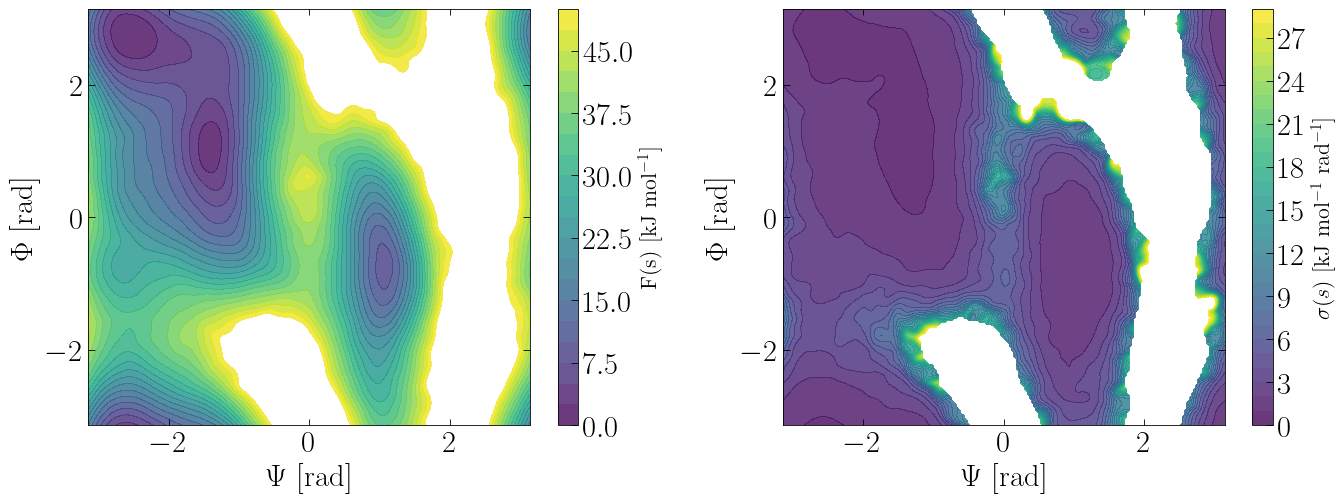

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, MFI.zero_to_nan(ofe*cutoff), levels=np.arange(0, 30, 1), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

# plt.savefig('Figure1B_1', dpi=600, bbox_inches='tight')

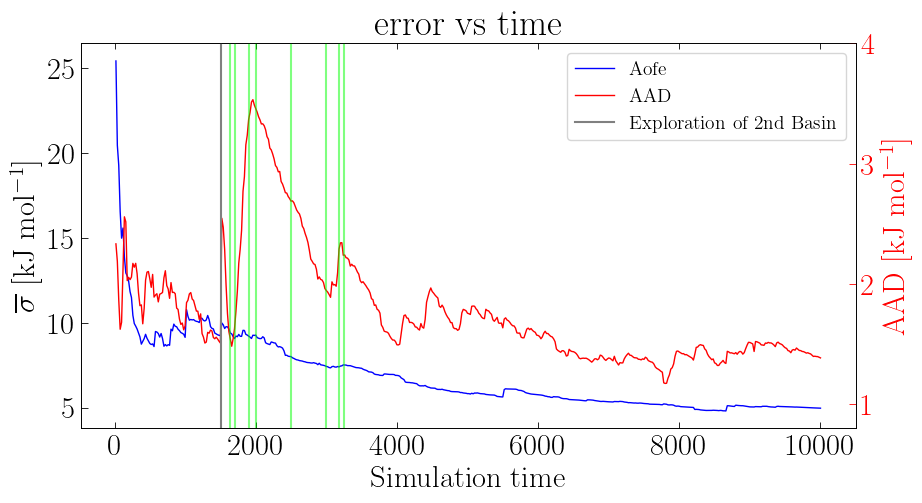

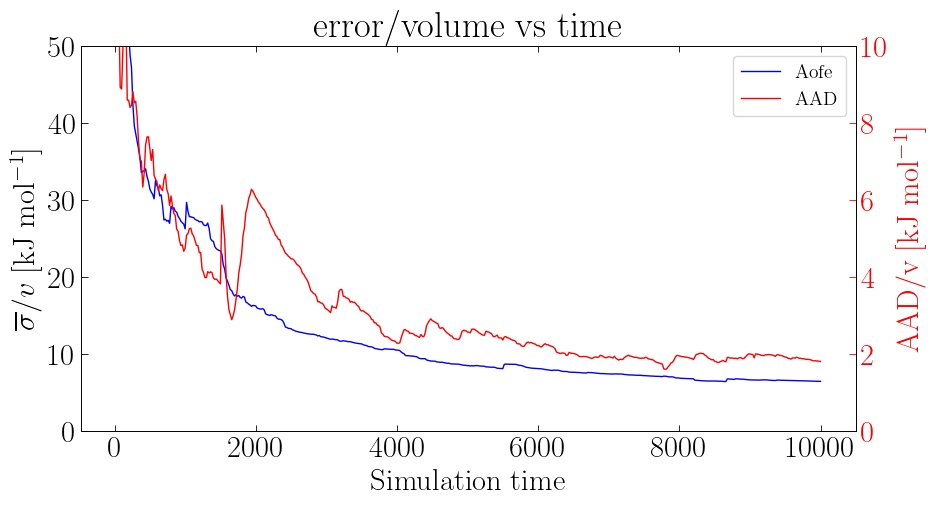

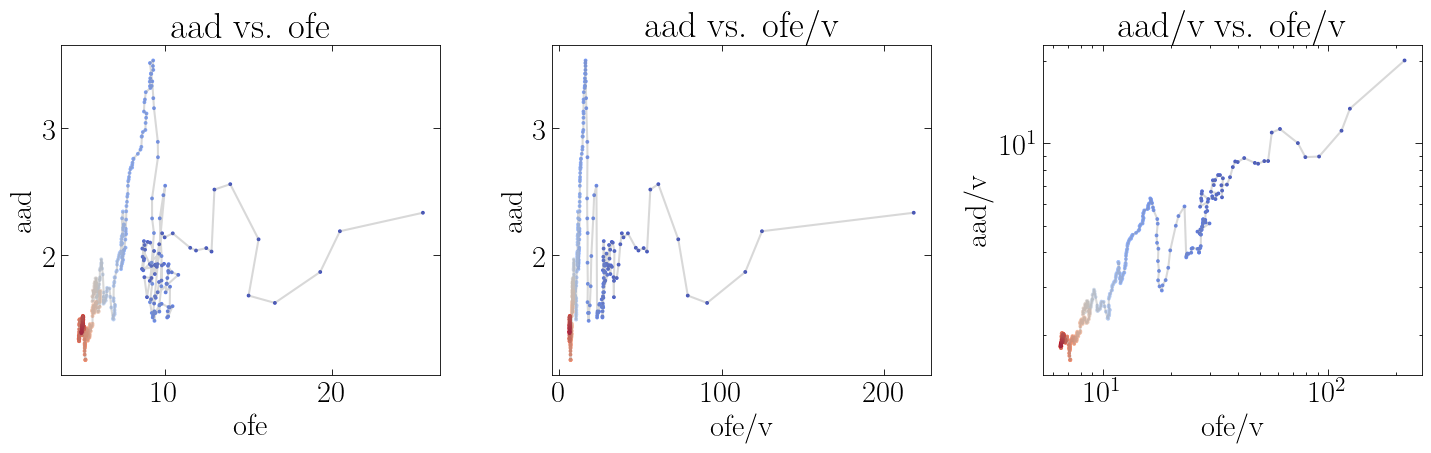

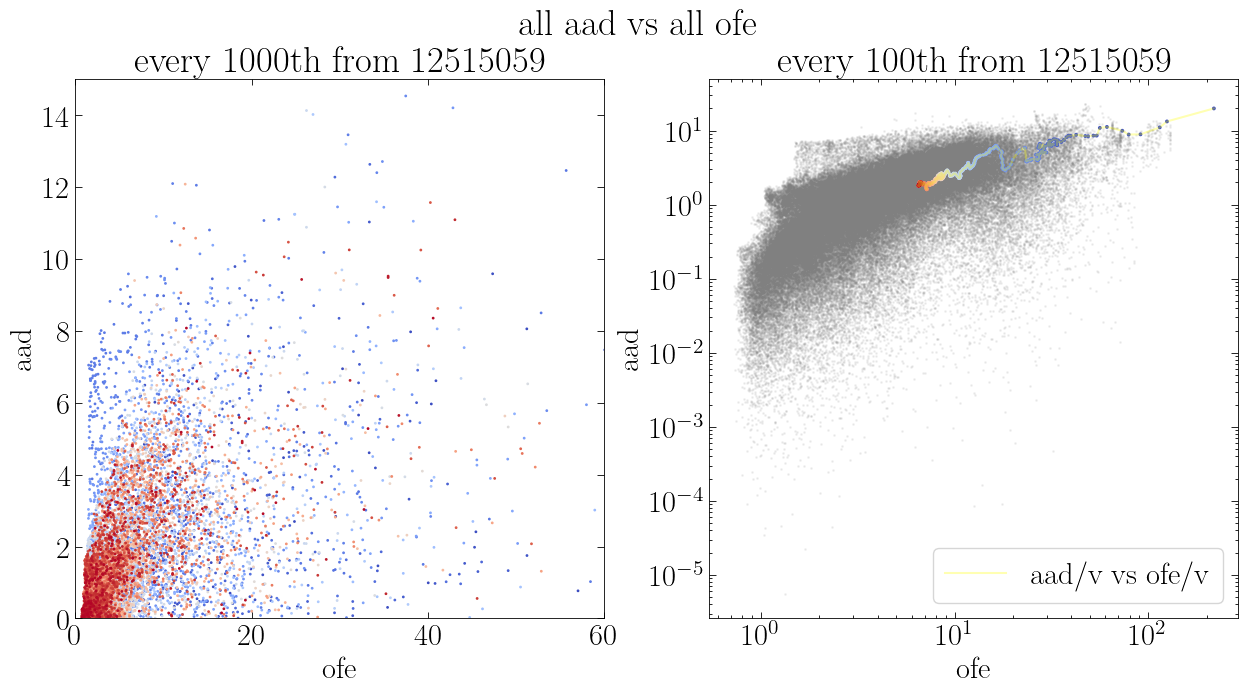

In [12]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot( time_history_1, ofe_history_1 ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_1, np.asarray(aad_history_1)[:,1] ,color='red',linewidth=1,label="AAD")
ax2.plot([1511,1511], [0.8,4], c="grey", label="Exploration of 2nd Basin")
ax2.plot([1640,1640], [0.8,4], c="lime", alpha=0.5)
ax2.plot([1700,1700], [0.8,4], c="lime", alpha=0.5)
ax2.plot([1900,1900], [0.8,4], c="lime", alpha=0.5)
ax2.plot([2000,2000], [0.8,4], c="lime", alpha=0.5)
ax2.plot([2500,2500], [0.8,4], c="lime", alpha=0.5)
ax2.plot([3000,3000], [0.8,4], c="lime", alpha=0.5)
ax2.plot([3180,3180], [0.8,4], c="lime", alpha=0.5)
ax2.plot([3250,3250], [0.8,4], c="lime", alpha=0.5)

ax1.set_title("error vs time"); ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]", c="black"); ax2.set_ylabel("AAD [kJ mol$^{-1}$]", c="red"); ax2.tick_params('y', colors='r')
ax2.set_ylim(0.8,4)# ;ax2.set_ylim(0,5)

handles1, labels1 = ax1.get_legend_handles_labels(); handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
plt.show()

##############################################################################################################
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_1, np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,color='red',linewidth=1,label="AAD")
# ax2.plot([1511,1511], [1,7], c="grey", label="Exploration of 2nd Basin")
# ax2.plot([1640,1640], [1,7], c="lime", alpha=0.5)
# ax2.plot([1700,1700], [1,7], c="lime", alpha=0.5)
# ax2.plot([1900,1900], [1,7], c="lime", alpha=0.5)
# ax2.plot([2000,2000], [1,7], c="lime", alpha=0.5)
# ax2.plot([2500,2500], [1,7], c="lime", alpha=0.5)
# ax2.plot([3000,3000], [1,7], c="lime", alpha=0.5)
# ax2.plot([3180,3180], [1,7], c="lime", alpha=0.5)
# ax2.plot([3250,3250], [1,7], c="lime", alpha=0.5)
ax1.set_title("error/volume vs time"); ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="black"); ax2.set_ylabel("AAD/v [kJ mol$^{-1}$]", c="red"); ax2.tick_params('y', colors='r')

ax1.set_ylim(0,50)
ax2.set_ylim(0,10)# ; ax2.set_ylim(0,5)

# ax1.legend(); ax2.legend()
handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
plt.show()

##############################################################################################################

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(np.asarray(ofe_history_1) , np.asarray(aad_history_1)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) , np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
plt.title("aad vs. ofe"); plt.xlabel("ofe"); plt.ylabel("aad")

plt.subplot(1,3,2)
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1]  ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
plt.title("aad vs. ofe/v"); plt.xlabel("ofe/v"); plt.ylabel("aad")

plt.subplot(1,3,3)
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
plt.title("aad/v vs. ofe/v"); plt.xlabel("ofe/v"); plt.ylabel("aad/v"); plt.xscale("log"); plt.yscale("log")
plt.tight_layout(); plt.show()

##############################################################################################################

i = 1000
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
norm = plt.Normalize(0, len(all_aad[::i]))
plt.scatter(all_ofe[::i], all_aad[::i] ,s=1, c=range(len(all_aad[::i])), cmap=cmap, norm=norm)
plt.title("every " + str(i) + "th from " + str(len(all_aad))); plt.xlabel("ofe"); plt.ylabel("aad")
plt.ylim(0,15)#; 
plt.xlim(0,60);


plt.subplot(1,2,2)
i=100
norm = plt.Normalize(0, len(all_aad[::i]))
plt.scatter(all_ofe[::i], all_aad[::i] ,s=1, c="grey", alpha=0.1)
norm = plt.Normalize(0, len(ofe_history_1))
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) , c="yellow", alpha=0.3, label="aad/v vs ofe/v"); 
plt.title("every " + str(i) + "th from " + str(len(all_aad))); plt.xlabel("ofe"); plt.ylabel("aad"); 
plt.xscale("log"); plt.yscale("log")
# plt.ylim(0,15)#; 
# plt.xlim(0,60);
plt.suptitle("all aad vs all ofe"); plt.legend()
plt.show()


In [46]:
MFI.save_pkl([time_history_1, ofe_history_1, aad_history_1 ,volume_history_1], path_manustript +"Figure_E/" + "data_figure_E_1B.pkl")
# [time_history_1, ofe_history_1, aad_history_1 ,volume_history_1] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_1B.pkl")

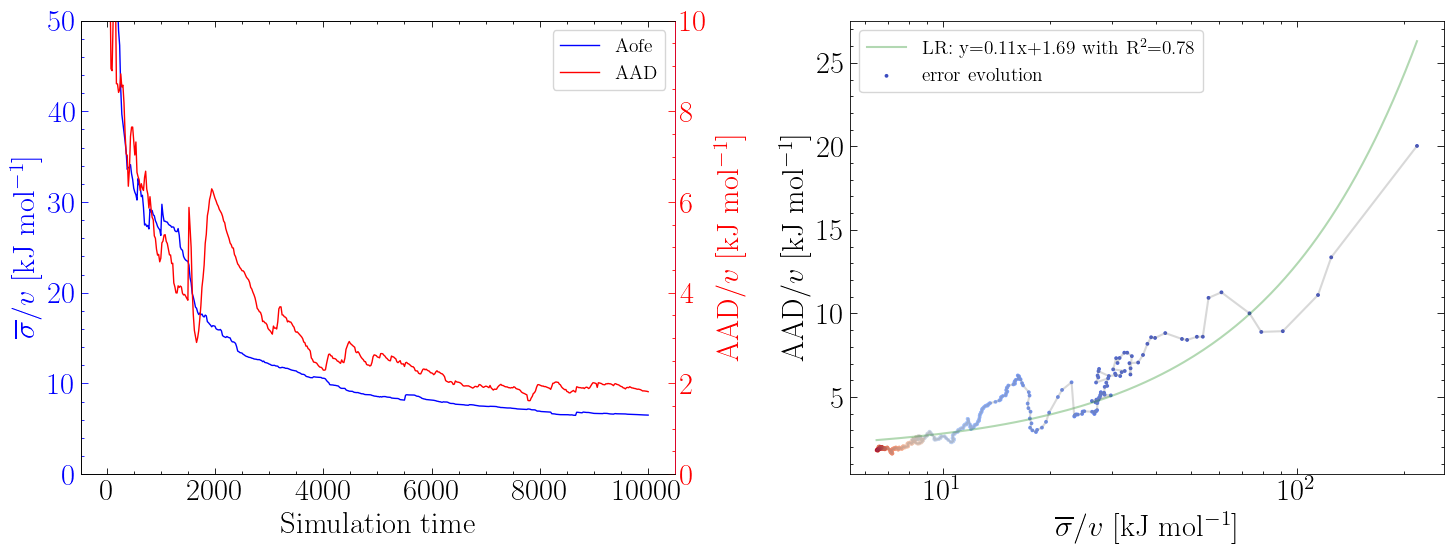

In [13]:
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

fig, (ax1, ax3) = plt.subplots(1,2,figsize=(15,6))
ax2 = ax1.twinx()

ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_1, np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,color='red',linewidth=1,label="AAD")
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,50)
ax2.set_ylim(0,10)
handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
from scipy import stats
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1))
x_line = np.linspace(min(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), max(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
ax3.plot(x_line, x_line*slope + intercept, c="green", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)))

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm, label="error evolution")
ax3.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log")#; plt.yscale("log");ax3.set_title("aad/v vs. ofe/v"); 
ax3.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)

plt.tight_layout()
plt.show()

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

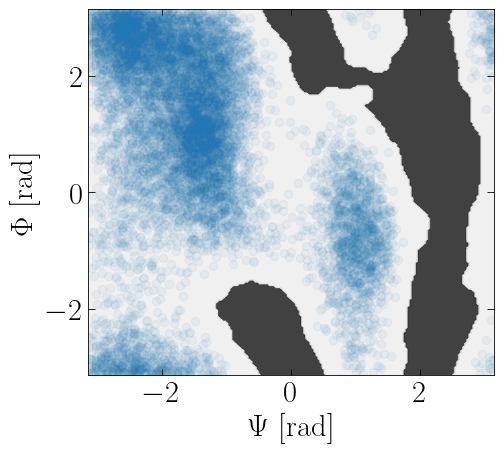

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()


# plt.savefig('Figure1B_3', dpi=600, bbox_inches='tight')

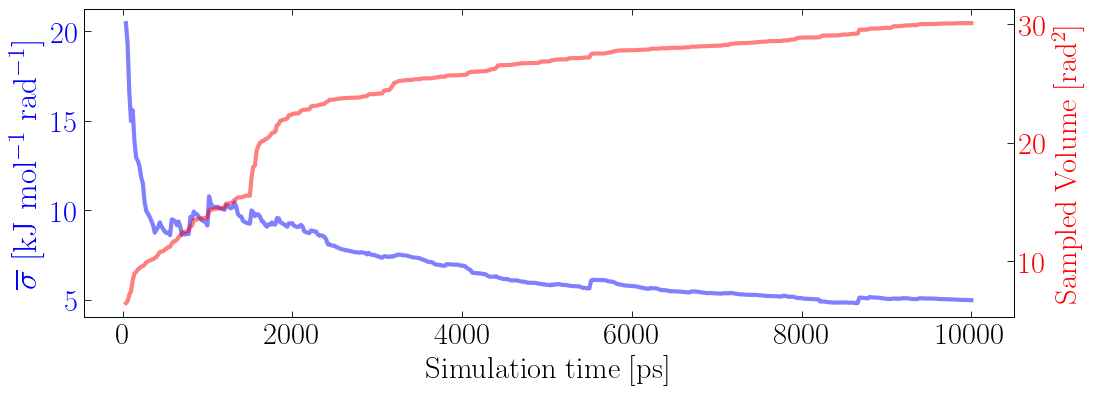

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in time_history[1:]], (ofe_history[1:NH]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$ rad$^{-1}$]',fontsize=24, color='blue')
axs.tick_params(axis ='y', labelcolor = 'blue')
axs.set_xlabel('Simulation time [ps]')

V=np.multiply(volume_history[1:NH],np.power(2*np.pi,2))
ax2 = axs.twinx()
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('Sampled Volume [rad$^2$]',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:NH],np.power(2*np.pi,2)),color='red',alpha=0.5,linewidth=3);

# plt.savefig('Figure1B_2', dpi=600, bbox_inches='tight')

In [18]:
def MFI_2D_plot(HILLS="HILLS", position_x="position_x", position_y="position_y", bw = np.array((0.1,0.1)), kT=1,
			min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)),
			error_pace=-1, base_terms = 0, window_corners=[], WellTempered=1, nhills=-1, periodic = np.array((1,1)), 
			Ftot_den_limit = 1E-10, FES_cutoff = -1, Ftot_den_cutoff = 0.1, non_exploration_pentaly=-1, use_weighted_st_dev = True,
			hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
			lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
			uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0, ref_fes = np.zeros((200,200)), hills_list=[]):
	"""Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 2D CV spaces.

	Args:
		HILLS (str): HILLS array. Defaults to "HILLS".
		position_x (str): CV1 array. Defaults to "position_x".
		position_y (str): CV2 array. Defaults to "position_y".
		bw (int, optional): Scalar, bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
		kT (int, optional): Scalar, kT. Defaults to 1.
		min_grid (array, optional): Lower bound of the force domain. Defaults to np.array((-np.pi, -np.pi)).
		max_grid (array, optional): Upper bound of the force domain. Defaults to np.array((np.pi, np.pi)).
		nbins (array, optional): number of bins in CV2,CV1. First enrty is the number of bins in CV2 and the second entry is the number of bins in CV1! Defaults to np.array((200,200)). 
		error_pace (int, optional): Pace for the calculation of the on-the-fly measure of global convergence. Defaults to 1, change it to a higher value if FES_cutoff>0 is used. 
		base_terms (int or list, optional): When set to 0, inactive. When activated, "on the fly" variance is calculated as a patch to base (previous) simulation. To activate, put force terms of base simulation ([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]). Defaults to 0.
		window_corners (list, optional): When set to [], inactive. When activated, error is ALSO calculated for mean force in the window. To activate, put the min and max values of the window ([min_x, max_x, min_y, max_y]). Defaults to [].
		WellTempered (binary, optional): Is the simulation well tempered? . Defaults to 1.
		nhills (int, optional): Number of HILLS to analyse, -1 for the entire HILLS array. Defaults to -1, i.e. the entire dataset.
		periodic (int, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
		Ftot_den_limit (float, optional): Truncation of the probability density for numerical reasons, to avaiod devisions by zero (or suare root of negative numbers). If the probability density (Ftot_den) of some CV region is lover than the Ftot_den_limit, it will be set to zero. Default is set to 1E-10.
		FES_cutoff (float, optional): Cutoff applied to error calculation for FES values over the FES_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0. When FES_cutoff <= 0, no cufoff is applied. Use with care, computing the fes in the loop renders the calculation slow.
		Ftot_den_cutoff (float, optional): Cutoff applied to error calculation for probability density (Ftot_den) values below the Ftot_den_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0.1. When Ftot_den_cutoff <= 0, no cufoff is applied. 
		non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
		hp_centre_x (float, optional): CV1-position of harmonic potential. Defaults to 0.0.
		hp_centre_y (float, optional): CV2-position of harmonic potential. Defaults to 0.0.
		hp_kappa_x (int, optional): CV1-force_constant of harmonic potential. Defaults to 0.
		hp_kappa_y (int, optional): CV2-force_constant of harmonic potential. Defaults to 0.
		lw_centre_x (float, optional): CV1-position of lower wall potential. Defaults to 0.0.
		lw_centre_y (float, optional): CV2-position of lower wall potential. Defaults to 0.0.
		lw_kappa_x (int, optional): CV1-force_constant of lower wall potential. Defaults to 0.
		lw_kappa_y (int, optional): CV2-force_constant of lower wall potential. Defaults to 0.
		uw_centre_x (float, optional): CV1-position of upper wall potential. Defaults to 0.0.
		uw_centre_y (float, optional): CV2-position of upper wall potential. Defaults to 0.0.
		uw_kappa_x (int, optional): CV1-force_constant of upper wall potential. Defaults to 0.
		uw_kappa_y (int, optional): CV2-force_constant of upper wall potential. Defaults to 0.

	Returns:
		X: array of size (nbins[0], nbins[1]) - CV1 grid positions
		Y: array of size (nbins[0], nbins[1]) - CV2 grid positions
		Ftot_den: array of size (nbins[0], nbins[1]) - Cumulative biased probability density, equivalent to an unbiased histogram of samples in CV space.
		Ftot_x:  array of size (nbins[0], nbins[1]) - CV1 component of the Mean Force.
		Ftot_y:  array of size (nbins[0], nbins[1]) - CV2 component of the Mean Force.
		ofe:  array of size (nbins[0], nbins[1]) - on the fly estimate of the local convergence
		ofe_history: array of size (1, total_number_of_hills) - running estimate of the global convergence of the mean force.
		(option with window corner activated: ofe_history_window: array of size (1, total_number_of_hills) - running estimate of the "window" convergence of the mean force.)
		ofe_history_time: array of size (1, total_number_of_hills) - time array of ofe_history
		Ftot_den2: array of size (nbins[0], nbins[1]) - Cumulative squared biased probability density
		ofv_x: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV1 "on the fly variance" ( sum of: pb_t * dfds_x ** 2)
		ofv_y: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV2 "on the fly variance" ( sum of: pb_t * dfds_y ** 2)
	"""

	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
	grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[1]-1), (max_grid[1] - min_grid[1]) / (nbins[0]-1)))
	X, Y = np.meshgrid(gridx, gridy)
	stride = int(len(position_x) / len(HILLS))
	bw_xy = np.sqrt(bw[0] * bw[1])
	bw_xy2  = bw_xy ** 2
	bw_x2 = bw[0] ** 2
	bw_y2 = bw[1] ** 2
	const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

	# Optional - analyse only nhills, if nhills is set
	if nhills > 0: total_number_of_hills = nhills
	else: total_number_of_hills = len(HILLS)
	if error_pace == -1: error_pace = int(total_number_of_hills / 100)
	elif error_pace == -2: error_pace = int(total_number_of_hills / 10)
	elif error_pace < 0: error_pace = total_number_of_hills
	if FES_cutoff > 0: FES_cutoff = [FES_cutoff, min_grid, max_grid, periodic]
 
	# Initialize force terms
	Fbias_x = np.zeros(nbins)
	Fbias_y = np.zeros(nbins)
	Ftot_num_x = np.zeros(nbins)
	Ftot_num_y = np.zeros(nbins)
	Ftot_den = np.zeros(nbins)
	Ftot_den2 = np.zeros(nbins)
	ofv_num_x = np.zeros(nbins)
	ofv_num_y = np.zeros(nbins)
	cutoff = np.ones(nbins)
	volume_history = []
	ofe_history = []
	aad_history = []
	time_history = []
	all_ofe = []
	all_aad = []
	if len(window_corners) == 4: ofe_history_window = []

	#Calculate static force
	F_static_x = np.zeros(nbins)
	F_static_y = np.zeros(nbins)
	if hp_kappa_x > 0 or hp_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_hp_force(hp_centre_x, hp_centre_y, hp_kappa_x, hp_kappa_y, X , Y, min_grid, max_grid, grid_space, periodic )
		F_static_x += Force_x
		F_static_y += Force_y
	if lw_kappa_x > 0 or lw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_lw_force(lw_centre_x, lw_centre_y, lw_kappa_x, lw_kappa_y, X , Y, periodic )
		F_static_x += Force_x
		F_static_y += Force_y
	if uw_kappa_x > 0 or uw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_uw_force(uw_centre_x, uw_centre_y, uw_kappa_x, uw_kappa_y, X , Y, periodic )
		F_static_x += Force_x
		F_static_y += Force_y

	# Definition Gamma Factor, allows to switch between WT and regular MetaD
	if WellTempered < 1: Gamma_Factor = 1
	else: Gamma_Factor = (HILLS[0, 6] - 1) / (HILLS[0, 6])
		
	for i in range(total_number_of_hills):
		
		# Build metadynamics potential
		s_x = HILLS[i, 1]  # centre x-position of Gaussian
		s_y = HILLS[i, 2]  # centre y-position of Gaussian
		sigma_meta2_x = HILLS[i, 3] ** 2  # width of Gaussian
		sigma_meta2_y = HILLS[i, 4] ** 2  # width of Gaussian
		height_meta = HILLS[i, 5] * Gamma_Factor  # Height of Gaussian

		periodic_images = MFI.find_periodic_point(s_x, s_y, min_grid, max_grid, periodic)
		for j in range(len(periodic_images)):
			kernelmeta_x = np.exp( - np.square(gridx - periodic_images[j][0]) / (2 * sigma_meta2_x)) * height_meta
			kernelmeta_y = np.exp( - np.square(gridy - periodic_images[j][1]) / (2 * sigma_meta2_y))
			Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - periodic_images[j][0])) / sigma_meta2_x )
			Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - periodic_images[j][1])) / sigma_meta2_y, kernelmeta_x )

		# Estimate the biased proabability density p_t ^ b(s)
		pb_t = np.zeros(nbins)
		Fpbt_x = np.zeros(nbins)
		Fpbt_y = np.zeros(nbins)

		data_x = position_x[i * stride: (i + 1) * stride]
		data_y = position_y[i * stride: (i + 1) * stride]

		for j in range(stride):
			periodic_images = MFI.find_periodic_point(data_x[j], data_y[j], min_grid, max_grid, periodic)
			for k in range(len(periodic_images)):
				kernel_x = np.exp( - np.square(gridx - periodic_images[k][0]) / (2 * bw_x2)) * const #add constant here for less computations
				kernel_y = np.exp( - np.square(gridy - periodic_images[k][1]) / (2 * bw_y2))
				kernel = np.outer(kernel_y, kernel_x)
				kernel_x *= kT / bw_xy2 #add constant here for less computations

				pb_t += kernel
				Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - periodic_images[k][0])) )
				Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - periodic_images[k][1])) , kernel_x )

		# Calculate total probability density
		pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
		Ftot_den += pb_t
		
		# Calculate x-component of Force
		dfds_x = np.divide(Fpbt_x, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t > 0) + Fbias_x - F_static_x
		Ftot_num_x += np.multiply(pb_t, dfds_x)
		
		# Calculate y-component of Force
		dfds_y = np.divide(Fpbt_y, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t > 0) + Fbias_y - F_static_y
		Ftot_num_y += np.multiply(pb_t, dfds_y)

		# calculate on the fly error components
		Ftot_den2 += np.square(pb_t)
		ofv_num_x += np.multiply(pb_t, np.square(dfds_x))
		ofv_num_y += np.multiply(pb_t, np.square(dfds_y))
  

		if (i + 1) % int(error_pace) == 0 or (i+1) == total_number_of_hills or (i+1)==hills_list[0] or (i+1)==hills_list[1] or (i+1)==hills_list[2] or (i+1)==hills_list[3] or (i+1)==hills_list[4] or (i+1)==hills_list[5] or (i+1)==hills_list[6] or (i+1)==hills_list[7] or (i+1)==hills_list[8] or (i+1)==hills_list[9] or (i+1)==hills_list[10] or (i+1)==hills_list[11] or (i+1)==hills_list[12]:
			#calculate forces
			Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den > 0)
			Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den > 0)

			# calculate ofe (standard error)
			if base_terms == 0:
				[ofv, ofe] = MFI.mean_force_variance(Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y, use_weighted_st_dev=use_weighted_st_dev)
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot] = [np.array(Ftot_den), np.array(Ftot_x), np.array(Ftot_y)]
			elif len(base_terms) == 6:
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot, ofv, ofe] = MFI.patch_to_base_variance(base_terms, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

			# If specified, apply cutoff to error and/or non_exploration_pentaly
			if Ftot_den_cutoff > 0 or hasattr(FES_cutoff, "__len__"): cutoff = MFI.get_cutoff(Ftot_den_tot, Ftot_den_cutoff=Ftot_den_cutoff, FX=Ftot_x_tot, FY=Ftot_y_tot, FES_cutoff=FES_cutoff)			
			if non_exploration_pentaly > 0: ofe = np.where(cutoff > 0.5, ofe, non_exploration_pentaly)
			else: ofe *= cutoff
   
			# ofe = np.where(ref_fes < 19, ofe, 0)

			#Calculate averaged global error
			absolute_explored_volume = np.count_nonzero(cutoff)
			# if i ==0: print("ofe is cut where inve_Pot < 19")
			volume_history.append( absolute_explored_volume/(nbins[0]*nbins[1]))
			if non_exploration_pentaly <= 0: ofe_history.append( np.sum(ofe) / absolute_explored_volume)
			else: ofe_history.append( np.sum(ofe) / (nbins[0]*nbins[1]))
			time_history.append(HILLS[i,0] + HILLS[2,0] - HILLS[1,0])
			if len(window_corners) == 4:
				ofe_cut_window = MFI.reduce_to_window(ofe, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3]) 
				ofe_history_window.append(np.sum(ofe_cut_window) / (np.count_nonzero(ofe_cut_window)))
    
    
			#Find Absolute devaition
			[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_tot, Ftot_y_tot, min_grid=min_grid, max_grid=max_grid)
			AD = abs(ref_fes - FES)
			ADc = AD * cutoff
			# ADc = np.where(ref_fes < 19, ADc, 0)
			AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
			AADc = np.sum(ADc)/(np.count_nonzero(ADc))
			aad_history.append([AAD,AADc])

			for ii in range(len(ofe)):
				for jj in range(len(ofe[0])):
        
					if ofe[ii][jj] != 0: 
						all_ofe.append(ofe[ii][jj])
						all_aad.append(ADc[ii][jj])

			#print progress
			if error_pace < 100: 	
				if (i+1) % 100 == 0:
					MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))  
			else: MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))  
			# if len(window_corners) == 4: print("    ||    Error in window", ofe_history_window[-1])
   
   
			for number in hills_list:
				if number == (i+1) or number == (i+1) or number == (i+1) or number == (i+1):
					fig, axs = plt.subplots(1, 4, figsize=(20, 5))
					levels = np.logspace(np.log10(0.1), np.log10(1000), 21)
					cp = axs[0].contourf(X, Y, np.where(Ftot_den > 0, Ftot_den, np.nan), levels=levels, norm=LogNorm(), cmap='viridis')#, antialiased=False, alpha=0.8);
					cbar = plt.colorbar(cp, ax=axs[0]); axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]')
					axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y)); axs[0].set_title("Ftot_den")

					cp = axs[1].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
					cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=8); axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]')
					axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y)); 
					axs[1].scatter(HILLS[:(i+1),1],HILLS[:(i+1),2],s=1); axs[1].set_title("FES")

					cp = axs[2].contourf(X, Y, ofe*cutoff, levels=np.arange(15, 60, 5), cmap='viridis', antialiased=False, alpha=0.8);
					cbar = plt.colorbar(cp, ax=axs[2]); cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=8); axs[2].set_ylabel('$\Phi$ [rad]'); axs[2].set_xlabel('$\Psi$ [rad]')
					axs[2].set_xlim(np.min(X),np.max(X)); axs[2].set_ylim(np.min(Y),np.max(Y)); axs[2].set_title("OFE")
     
					axs[3].plot( time_history, np.asarray(aad_history)[:,1] / np.asarray(volume_history) ,color='red',linewidth=1,label="AAD/v")
					axs[3].plot([1511,1511], [1,7], c="grey", label="Exploration of 2nd Basin")

					i_list = hills_list.index(i+1)
					for iii in hills_list[1:(i_list+1)]:
						axs[3].plot([iii+1,iii+1], [1,7], c="lime", alpha=0.5)

					axs[3].set_title("aad/volume vs time"); axs[3].set_xlabel("Simulation time"); axs[3].set_ylabel("AAD/v [kJ mol$^{-1}$]", c="red")
					# axs[3].set_ylim(1,7)# ; ax2.set_ylim(0,5)

					plt.suptitle("time " + str(i+1)); fig.tight_layout(); plt.show()

			
	if len(window_corners) == 4: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
  
	else: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad]



# def MFI_2D_plot(HILLS="HILLS", position_x="position_x", position_y="position_y", bw_x=0.1, bw_y=0.1, kT=1,
# 			min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)),
# 			error_pace=-1, base_terms = 0, window_corners=[], WellTempered=1, nhills=-1, periodic_x=0, periodic_y=0, 
# 			Ftot_den_limit = 1E-10, FES_cutoff = -1, Ftot_den_cutoff = 0.1, non_exploration_pentaly=-1, use_weighted_st_dev = True,
# 			hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
# 			lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
# 			uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0, ref_fes = np.zeros((200,200)), hills_list=[]):
# 	"""Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 2D CV spaces.

# 	Args:
# 		HILLS (str): HILLS array. Defaults to "HILLS".
# 		position_x (str): CV1 array. Defaults to "position_x".
# 		position_y (str): CV2 array. Defaults to "position_y".
# 		bw (int, optional): Scalar, bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
# 		kT (int, optional): Scalar, kT. Defaults to 1.
# 		min_grid (array, optional): Lower bound of the force domain. Defaults to np.array((-np.pi, -np.pi)).
# 		max_grid (array, optional): Upper bound of the force domain. Defaults to np.array((np.pi, np.pi)).
# 		nbins (array, optional): number of bins in CV2,CV1. First enrty is the number of bins in CV2 and the second entry is the number of bins in CV1! Defaults to np.array((200,200)). 
# 		error_pace (int, optional): Pace for the calculation of the on-the-fly measure of global convergence. Defaults to 1, change it to a higher value if FES_cutoff>0 is used. 
# 		base_terms (int or list, optional): When set to 0, inactive. When activated, "on the fly" variance is calculated as a patch to base (previous) simulation. To activate, put force terms of base simulation ([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]). Defaults to 0.
# 		window_corners (list, optional): When set to [], inactive. When activated, error is ALSO calculated for mean force in the window. To activate, put the min and max values of the window ([min_x, max_x, min_y, max_y]). Defaults to [].
# 		WellTempered (binary, optional): Is the simulation well tempered? . Defaults to 1.
# 		nhills (int, optional): Number of HILLS to analyse, -1 for the entire HILLS array. Defaults to -1, i.e. the entire dataset.
# 		periodic (int, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
# 		Ftot_den_limit (float, optional): Truncation of the probability density for numerical reasons, to avaiod devisions by zero (or suare root of negative numbers). If the probability density (Ftot_den) of some CV region is lover than the Ftot_den_limit, it will be set to zero. Default is set to 1E-10.
# 		FES_cutoff (float, optional): Cutoff applied to error calculation for FES values over the FES_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0. When FES_cutoff <= 0, no cufoff is applied. Use with care, computing the fes in the loop renders the calculation slow.
# 		Ftot_den_cutoff (float, optional): Cutoff applied to error calculation for probability density (Ftot_den) values below the Ftot_den_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0.1. When Ftot_den_cutoff <= 0, no cufoff is applied. 
# 		non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
# 		hp_centre_x (float, optional): CV1-position of harmonic potential. Defaults to 0.0.
# 		hp_centre_y (float, optional): CV2-position of harmonic potential. Defaults to 0.0.
# 		hp_kappa_x (int, optional): CV1-force_constant of harmonic potential. Defaults to 0.
# 		hp_kappa_y (int, optional): CV2-force_constant of harmonic potential. Defaults to 0.
# 		lw_centre_x (float, optional): CV1-position of lower wall potential. Defaults to 0.0.
# 		lw_centre_y (float, optional): CV2-position of lower wall potential. Defaults to 0.0.
# 		lw_kappa_x (int, optional): CV1-force_constant of lower wall potential. Defaults to 0.
# 		lw_kappa_y (int, optional): CV2-force_constant of lower wall potential. Defaults to 0.
# 		uw_centre_x (float, optional): CV1-position of upper wall potential. Defaults to 0.0.
# 		uw_centre_y (float, optional): CV2-position of upper wall potential. Defaults to 0.0.
# 		uw_kappa_x (int, optional): CV1-force_constant of upper wall potential. Defaults to 0.
# 		uw_kappa_y (int, optional): CV2-force_constant of upper wall potential. Defaults to 0.

# 	Returns:
# 		X: array of size (nbins[0], nbins[1]) - CV1 grid positions
# 		Y: array of size (nbins[0], nbins[1]) - CV2 grid positions
# 		Ftot_den: array of size (nbins[0], nbins[1]) - Cumulative biased probability density, equivalent to an unbiased histogram of samples in CV space.
# 		Ftot_x:  array of size (nbins[0], nbins[1]) - CV1 component of the Mean Force.
# 		Ftot_y:  array of size (nbins[0], nbins[1]) - CV2 component of the Mean Force.
# 		ofe:  array of size (nbins[0], nbins[1]) - on the fly estimate of the local convergence
# 		ofe_history: array of size (1, total_number_of_hills) - running estimate of the global convergence of the mean force.
# 		(option with window corner activated: ofe_history_window: array of size (1, total_number_of_hills) - running estimate of the "window" convergence of the mean force.)
# 		ofe_history_time: array of size (1, total_number_of_hills) - time array of ofe_history
# 		Ftot_den2: array of size (nbins[0], nbins[1]) - Cumulative squared biased probability density
# 		ofv_x: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV1 "on the fly variance" ( sum of: pb_t * dfds_x ** 2)
# 		ofv_y: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV2 "on the fly variance" ( sum of: pb_t * dfds_y ** 2)
# 	"""

# 	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
# 	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
# 	grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[1]-1), (max_grid[1] - min_grid[1]) / (nbins[0]-1)))
# 	X, Y = np.meshgrid(gridx, gridy)
# 	stride = int(len(position_x) / len(HILLS))
# 	bw_xy = np.sqrt(bw_x * bw_y)
# 	bw_xy2  = bw_xy ** 2
# 	bw_x2 = bw_x ** 2
# 	bw_y2 = bw_y ** 2
# 	const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

# 	# Optional - analyse only nhills, if nhills is set
# 	if nhills > 0: total_number_of_hills = nhills
# 	else: total_number_of_hills = len(HILLS)
# 	if error_pace == -1: error_pace = int(total_number_of_hills / 100)
# 	elif error_pace == -2: error_pace = int(total_number_of_hills / 10)
# 	elif error_pace < 0: error_pace = total_number_of_hills
# 	if FES_cutoff > 0: FES_cutoff = [FES_cutoff, min_grid, max_grid, periodic_x, periodic_y]
 
# 	# Initialize force terms
# 	Fbias_x = np.zeros(nbins)
# 	Fbias_y = np.zeros(nbins)
# 	Ftot_num_x = np.zeros(nbins)
# 	Ftot_num_y = np.zeros(nbins)
# 	Ftot_den = np.zeros(nbins)
# 	Ftot_den2 = np.zeros(nbins)
# 	ofv_num_x = np.zeros(nbins)
# 	ofv_num_y = np.zeros(nbins)
# 	cutoff = np.ones(nbins)
# 	volume_history = []
# 	ofe_history = []
# 	aad_history = []
# 	time_history = []
# 	all_ofe = []
# 	all_aad = []
# 	if len(window_corners) == 4: ofe_history_window = []

# 	#Calculate static force
# 	F_static_x = np.zeros(nbins)
# 	F_static_y = np.zeros(nbins)
# 	if hp_kappa_x > 0 or hp_kappa_y > 0:
# 		[Force_x, Force_y] = MFI.find_hp_force(hp_centre_x, hp_centre_y, hp_kappa_x, hp_kappa_y, X , Y, min_grid, max_grid, grid_space, periodic_x, periodic_y)
# 		F_static_x += Force_x
# 		F_static_y += Force_y
# 	if lw_kappa_x > 0 or lw_kappa_y > 0:
# 		[Force_x, Force_y] = MFI.find_lw_force(lw_centre_x, lw_centre_y, lw_kappa_x, lw_kappa_y, X , Y, periodic_x, periodic_y)
# 		F_static_x += Force_x
# 		F_static_y += Force_y
# 	if uw_kappa_x > 0 or uw_kappa_y > 0:
# 		[Force_x, Force_y] = MFI.find_uw_force(uw_centre_x, uw_centre_y, uw_kappa_x, uw_kappa_y, X , Y, periodic_x, periodic_y)
# 		F_static_x += Force_x
# 		F_static_y += Force_y

# 	# Definition Gamma Factor, allows to switch between WT and regular MetaD
# 	if WellTempered < 1: Gamma_Factor = 1
# 	else: Gamma_Factor = (HILLS[0, 6] - 1) / (HILLS[0, 6])
		
# 	for i in range(total_number_of_hills):
		
# 		# Build metadynamics potential
# 		s_x = HILLS[i, 1]  # centre x-position of Gaussian
# 		s_y = HILLS[i, 2]  # centre y-position of Gaussian
# 		sigma_meta2_x = HILLS[i, 3] ** 2  # width of Gaussian
# 		sigma_meta2_y = HILLS[i, 4] ** 2  # width of Gaussian
# 		height_meta = HILLS[i, 5] * Gamma_Factor  # Height of Gaussian

# 		periodic_images = MFI.find_periodic_point(s_x, s_y, min_grid, max_grid, periodic_x=periodic_x, periodic_y=periodic_y)
# 		for j in range(len(periodic_images)):
# 			kernelmeta_x = np.exp( - np.square(gridx - periodic_images[j][0]) / (2 * sigma_meta2_x)) * height_meta
# 			kernelmeta_y = np.exp( - np.square(gridy - periodic_images[j][1]) / (2 * sigma_meta2_y))
# 			Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - periodic_images[j][0])) / sigma_meta2_x )
# 			Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - periodic_images[j][1])) / sigma_meta2_y, kernelmeta_x )

# 		# Estimate the biased proabability density p_t ^ b(s)
# 		pb_t = np.zeros(nbins)
# 		Fpbt_x = np.zeros(nbins)
# 		Fpbt_y = np.zeros(nbins)

# 		data_x = position_x[i * stride: (i + 1) * stride]
# 		data_y = position_y[i * stride: (i + 1) * stride]

# 		for j in range(stride):
# 			periodic_images = MFI.find_periodic_point(data_x[j], data_y[j], min_grid, max_grid, periodic_x, periodic_y)
# 			for k in range(len(periodic_images)):
# 				kernel_x = np.exp( - np.square(gridx - periodic_images[k][0]) / (2 * bw_x2)) * const #add constant here for less computations
# 				kernel_y = np.exp( - np.square(gridy - periodic_images[k][1]) / (2 * bw_y2))
# 				kernel = np.outer(kernel_y, kernel_x)
# 				kernel_x *= kT / bw_xy2 #add constant here for less computations

# 				pb_t += kernel
# 				Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - periodic_images[k][0])) )
# 				Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - periodic_images[k][1])) , kernel_x )

# 		# Calculate total probability density
# 		pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
# 		Ftot_den += pb_t
		
# 		# Calculate x-component of Force
# 		dfds_x = np.divide(Fpbt_x, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t > 0) + Fbias_x - F_static_x
# 		Ftot_num_x += np.multiply(pb_t, dfds_x)
		
# 		# Calculate y-component of Force
# 		dfds_y = np.divide(Fpbt_y, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t > 0) + Fbias_y - F_static_y
# 		Ftot_num_y += np.multiply(pb_t, dfds_y)

# 		# calculate on the fly error components
# 		Ftot_den2 += np.square(pb_t)
# 		ofv_num_x += np.multiply(pb_t, np.square(dfds_x))
# 		ofv_num_y += np.multiply(pb_t, np.square(dfds_y))
  

# 		if (i + 1) % int(error_pace) == 0 or (i+1) == total_number_of_hills or (i+1)==hills_list[0] or (i+1)==hills_list[1] or (i+1)==hills_list[2] or (i+1)==hills_list[3]:
# 			#calculate forces
# 			Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den > 0)
# 			Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den > 0)

# 			# calculate ofe (standard error)
# 			if base_terms == 0:
# 				[ofv, ofe] = MFI.mean_force_variance(Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y, use_weighted_st_dev=use_weighted_st_dev)
# 				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot] = [np.array(Ftot_den), np.array(Ftot_x), np.array(Ftot_y)]
# 			elif len(base_terms) == 6:
# 				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot, ofv, ofe] = MFI.patch_to_base_variance(base_terms, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

# 			# If specified, apply cutoff to error and/or non_exploration_pentaly
# 			if Ftot_den_cutoff > 0 or hasattr(FES_cutoff, "__len__"): cutoff = MFI.get_cutoff(Ftot_den_tot, Ftot_den_cutoff=Ftot_den_cutoff, FX=Ftot_x_tot, FY=Ftot_y_tot, FES_cutoff=FES_cutoff)			
# 			if non_exploration_pentaly > 0: ofe = np.where(cutoff > 0.5, ofe, non_exploration_pentaly)
# 			else: ofe *= cutoff
   
# 			# ofe = np.where(ref_fes < 19, ofe, 0)

# 			#Calculate averaged global error
# 			absolute_explored_volume = np.count_nonzero(cutoff)
# 			# if i ==0: print("ofe is cut where inve_Pot < 19")
# 			volume_history.append( absolute_explored_volume/(nbins[0]*nbins[1]))
# 			if non_exploration_pentaly <= 0: ofe_history.append( np.sum(ofe) / absolute_explored_volume)
# 			else: ofe_history.append( np.sum(ofe) / (nbins[0]*nbins[1]))
# 			time_history.append(HILLS[i,0] + HILLS[2,0] - HILLS[1,0])
# 			if len(window_corners) == 4:
# 				ofe_cut_window = MFI.reduce_to_window(ofe, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3]) 
# 				ofe_history_window.append(np.sum(ofe_cut_window) / (np.count_nonzero(ofe_cut_window)))
    
    
# 			#Find Absolute devaition
# 			[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_tot, Ftot_y_tot, min_grid=min_grid, max_grid=max_grid)
# 			AD = abs(ref_fes - FES)
# 			ADc = AD * cutoff
# 			# ADc = np.where(ref_fes < 19, ADc, 0)
# 			AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
# 			AADc = np.sum(ADc)/(np.count_nonzero(ADc))
# 			aad_history.append([AAD,AADc])

# 			for ii in range(len(ofe)):
# 				for jj in range(len(ofe[0])):
        
# 					if ofe[ii][jj] != 0: 
# 						all_ofe.append(ofe[ii][jj])
# 						all_aad.append(ADc[ii][jj])

# 			#print progress
# 			if error_pace < 100: 	
# 				if (i+1) % 100 == 0:
# 					MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))  
# 			else: MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))  
# 			# if len(window_corners) == 4: print("    ||    Error in window", ofe_history_window[-1])
   
   
# 			for number in hills_list:
# 				if number == (i+1) or number == (i+1) or number == (i+1) or number == (i+1):
# 					fig, axs = plt.subplots(1, 3, figsize=(16, 5))
# 					levels = np.logspace(np.log10(0.1), np.log10(1000), 21)
# 					cp = axs[0].contourf(X, Y, np.where(Ftot_den > 0, Ftot_den, np.nan), levels=levels, norm=LogNorm(), cmap='viridis')#, antialiased=False, alpha=0.8);
# 					cbar = plt.colorbar(cp, ax=axs[0]); axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]')
# 					axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y)); 

# 					cp = axs[1].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
# 					cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=8); axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]')
# 					axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y)); 
# 					axs[1].scatter(HILLS[:(i+1),1],HILLS[:(i+1),2],s=1)

# 					cp = axs[2].contourf(X, Y, ofe*cutoff, levels=np.arange(15, 60, 5), cmap='viridis', antialiased=False, alpha=0.8);
# 					cbar = plt.colorbar(cp, ax=axs[2]); cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=8); axs[2].set_ylabel('$\Phi$ [rad]'); axs[2].set_xlabel('$\Psi$ [rad]')
# 					axs[2].set_xlim(np.min(X),np.max(X)); axs[2].set_ylim(np.min(Y),np.max(Y))


# 					plt.suptitle(str(i)); fig.tight_layout(); plt.show()

			
# 	if len(window_corners) == 4: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
  
# 	else: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad]



|***********************                           | 45% | Average Mean Force Error: 31.064

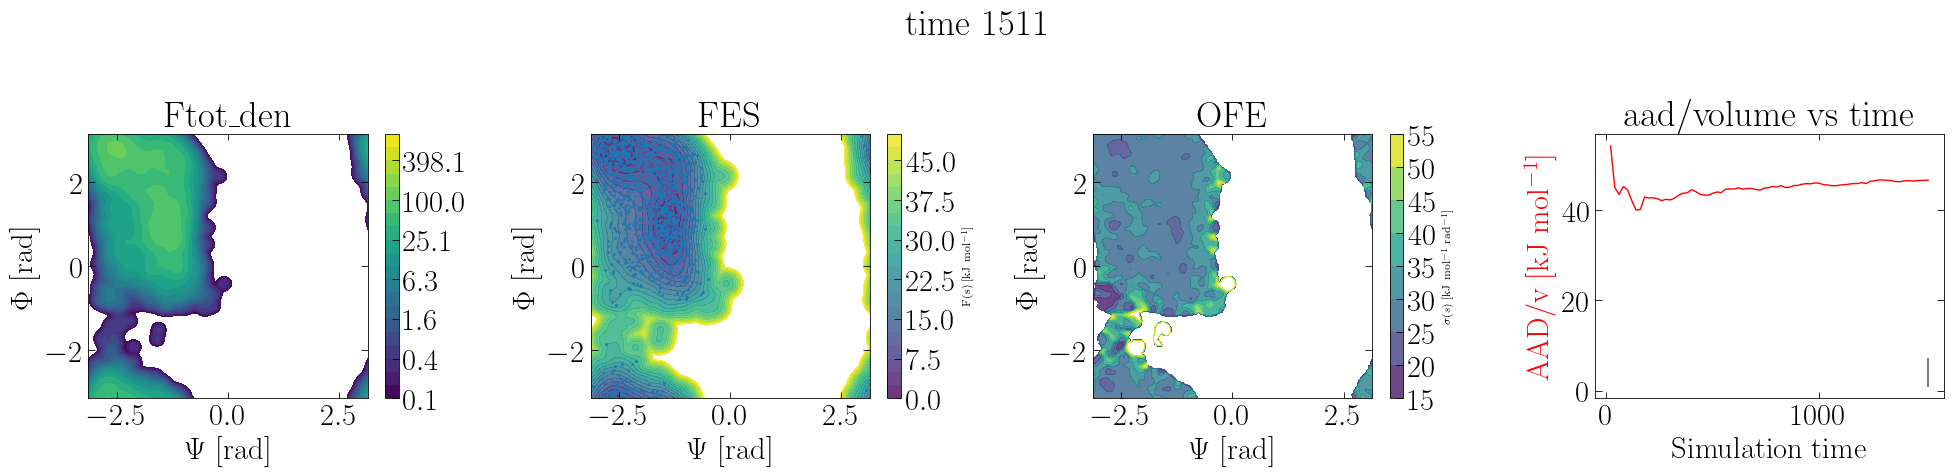

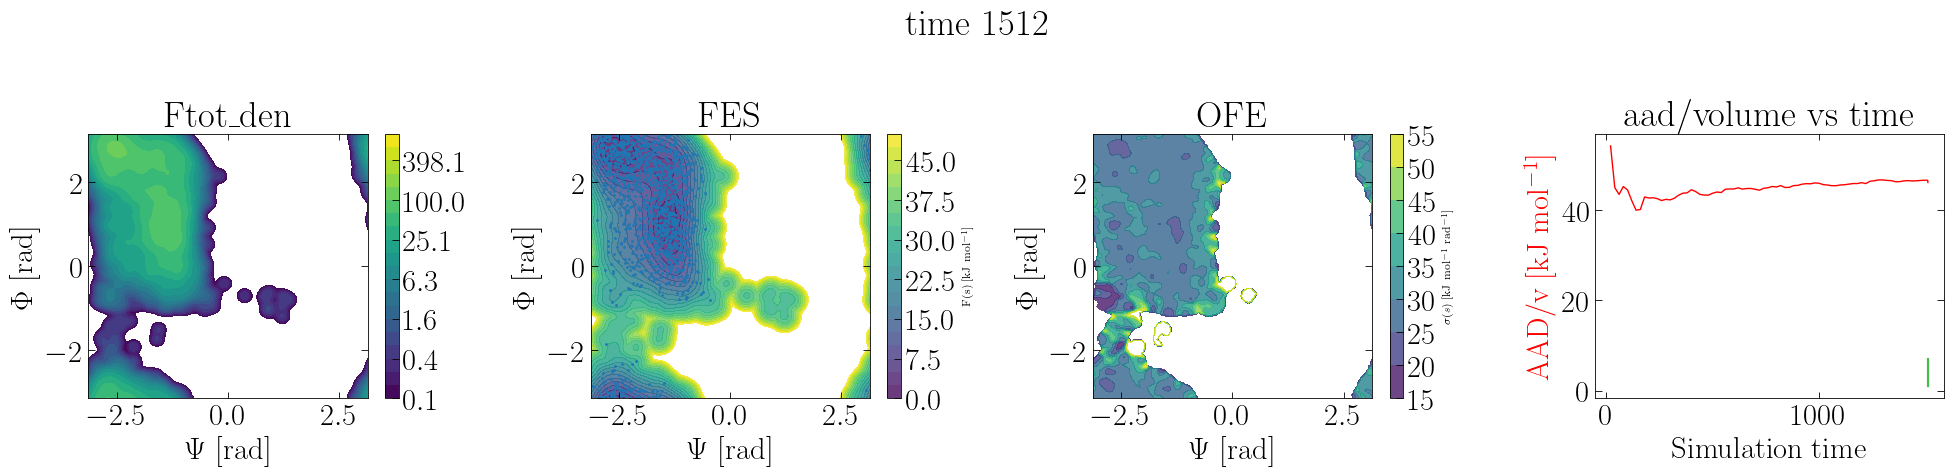

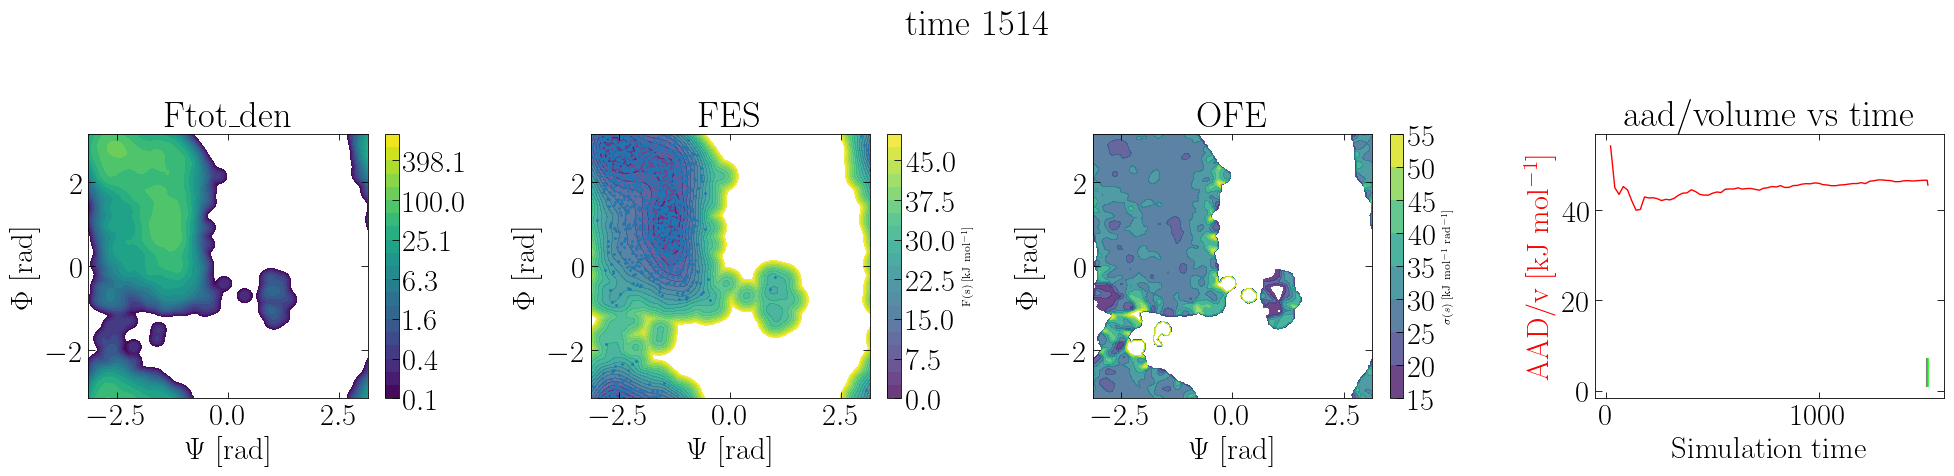

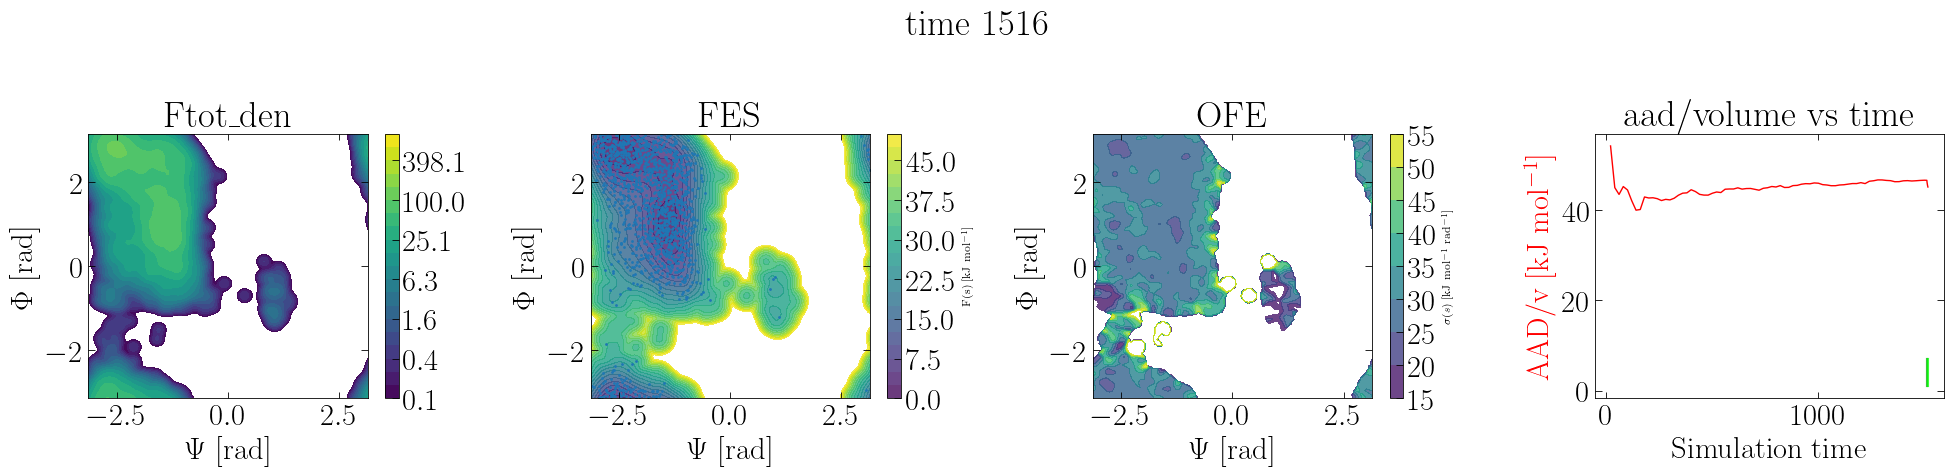

|************************                          | 48% | Average Mean Force Error: 30.556

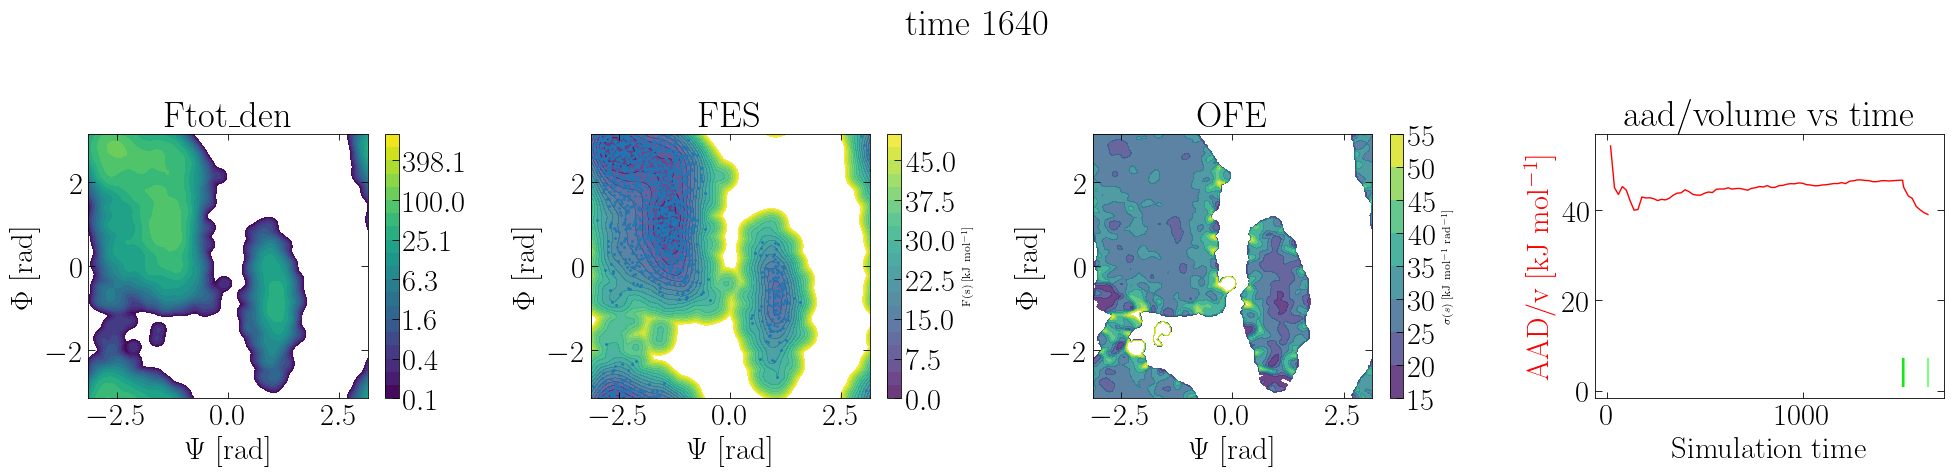

|**************************                        | 51% | Average Mean Force Error: 30.308

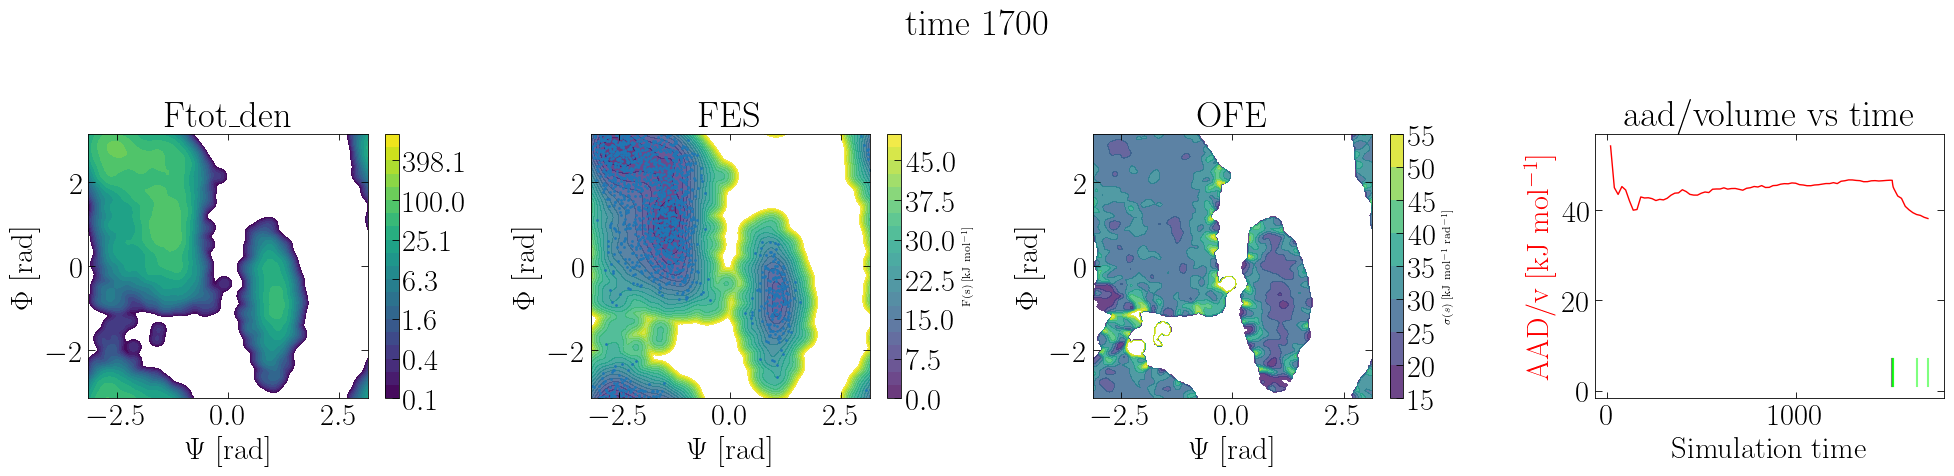

|*****************************                     | 57% | Average Mean Force Error: 30.532

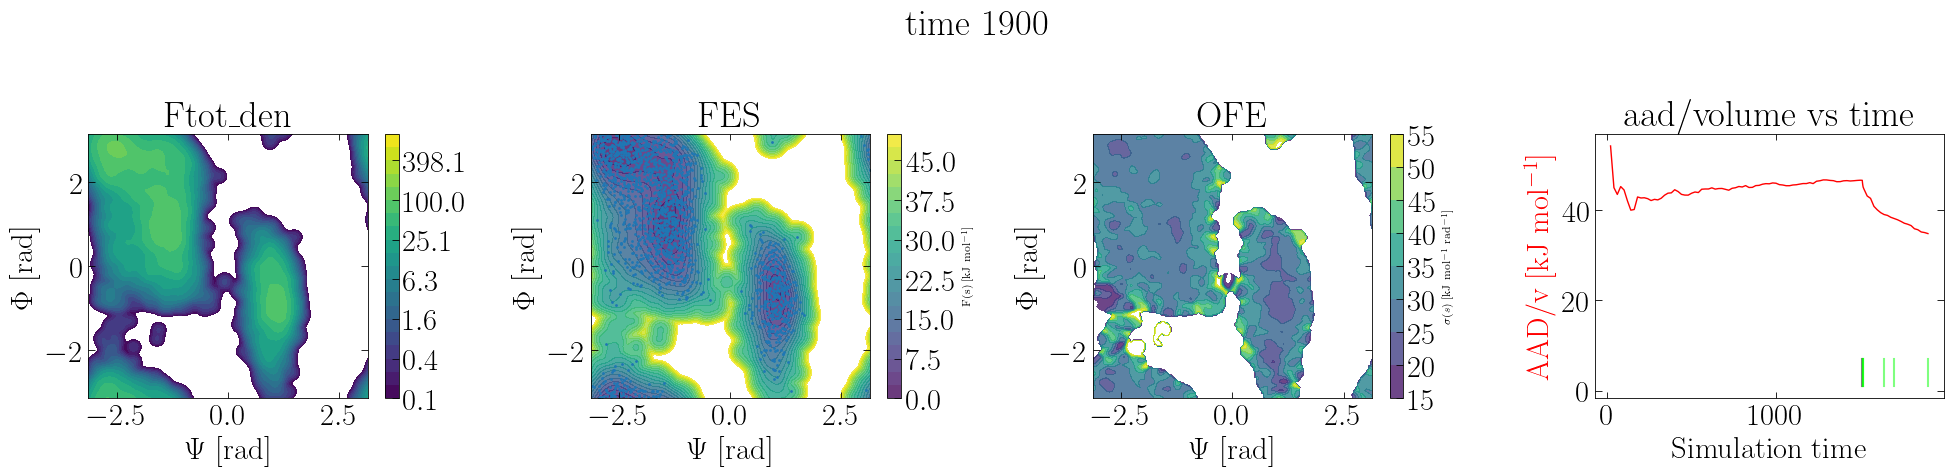

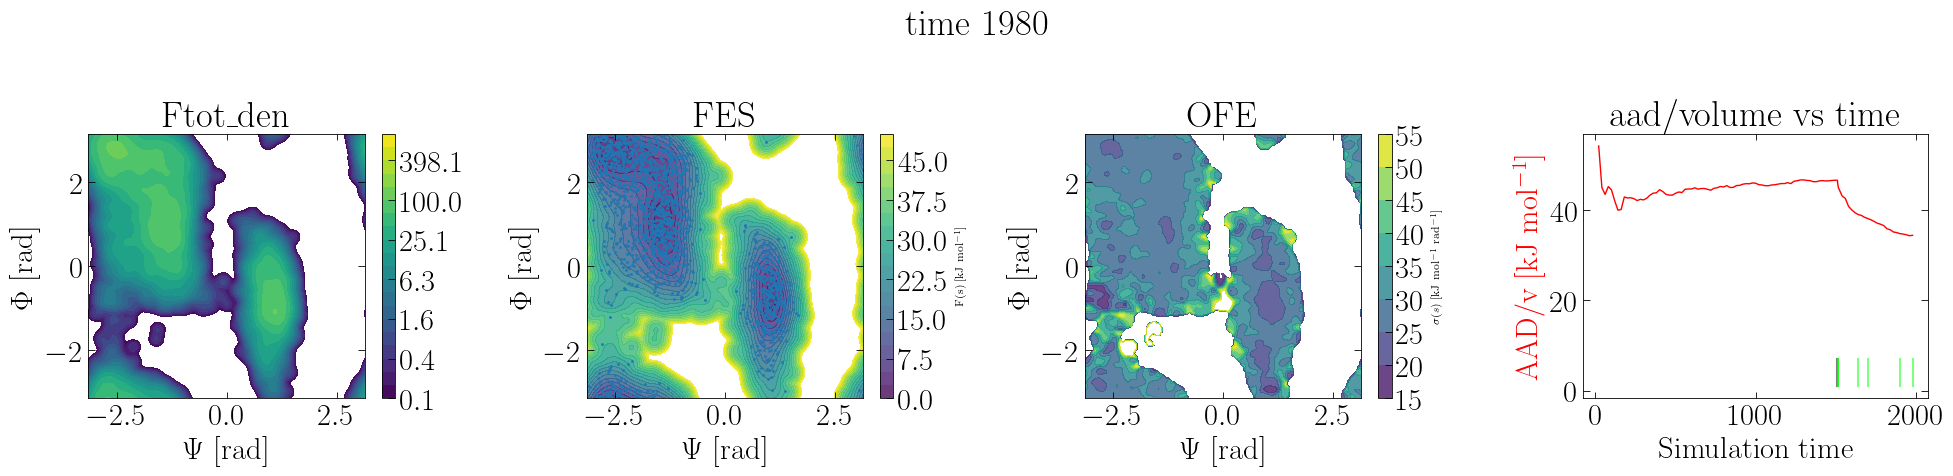

|******************************                    | 60% | Average Mean Force Error: 30.713

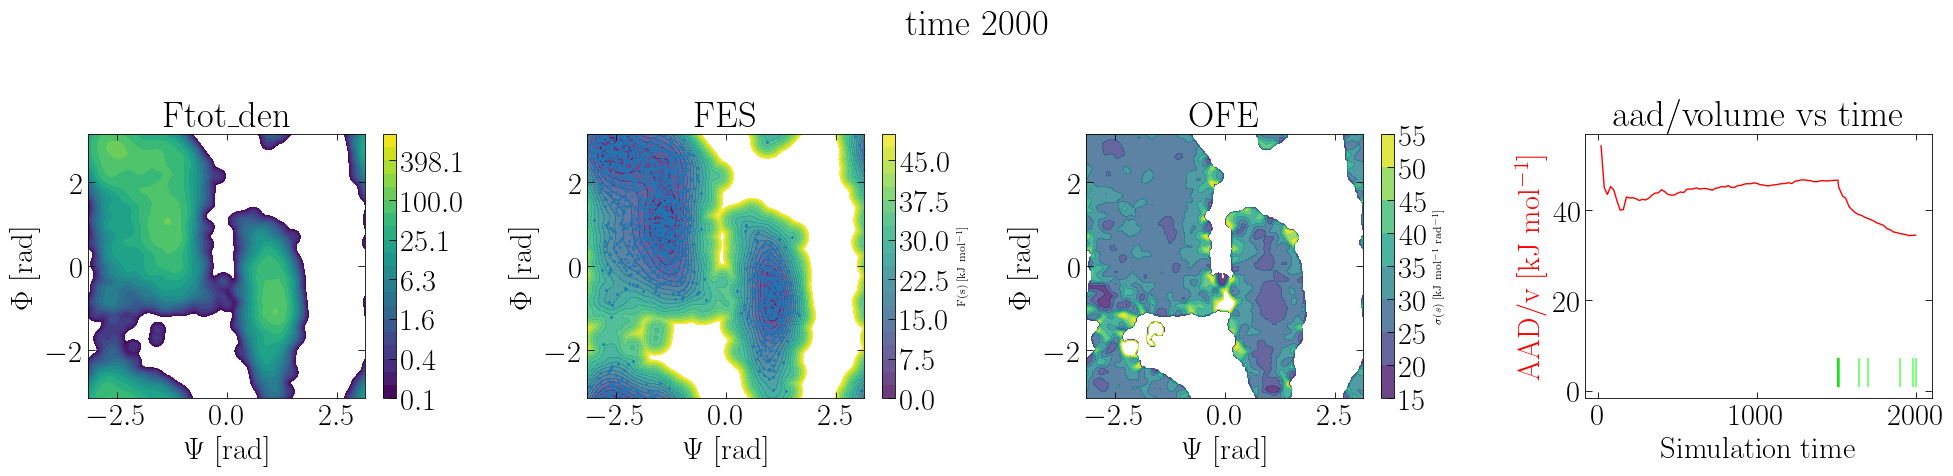

|**************************************            | 75% | Average Mean Force Error: 30.215

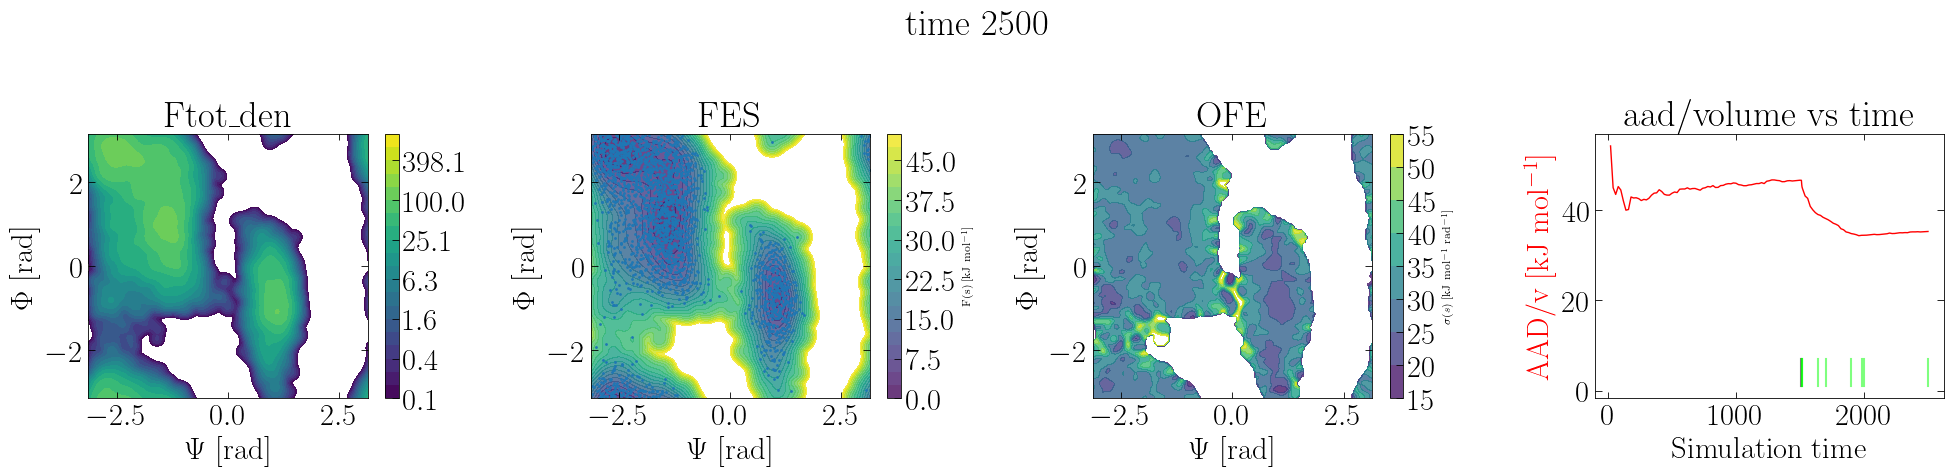

|*********************************************     | 90% | Average Mean Force Error: 30.001

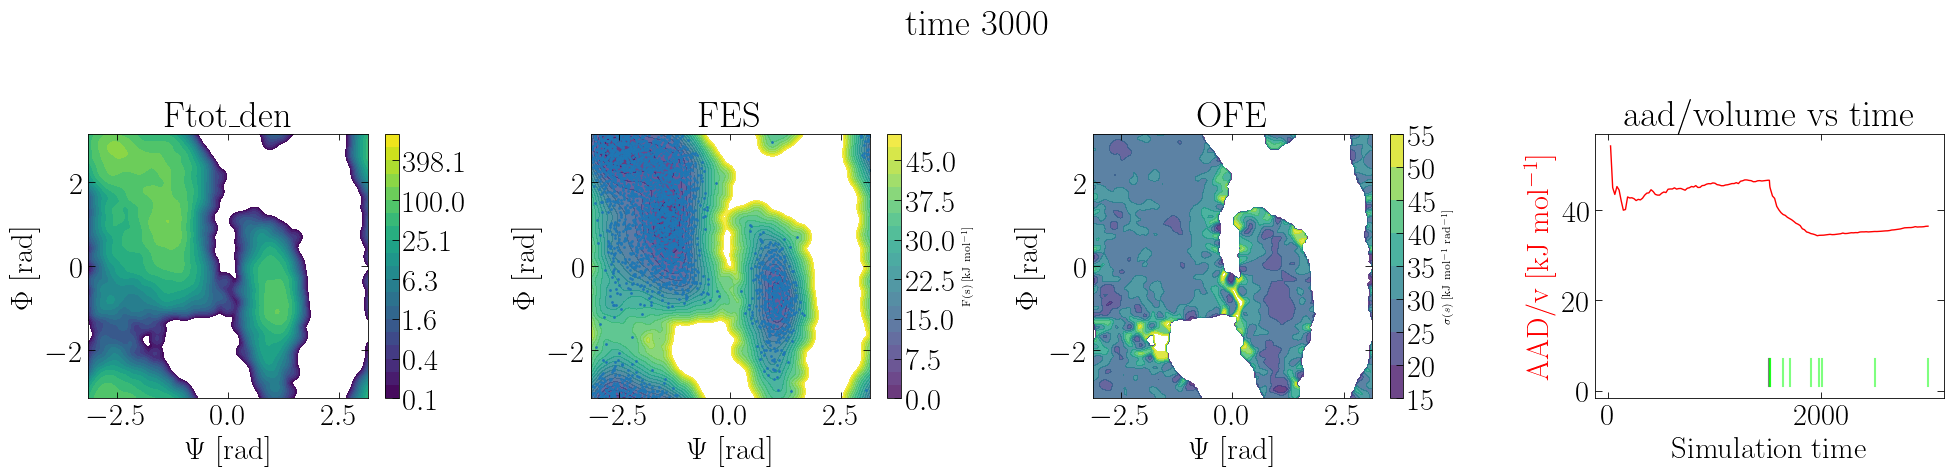

|***********************************************   | 93% | Average Mean Force Error: 30.111

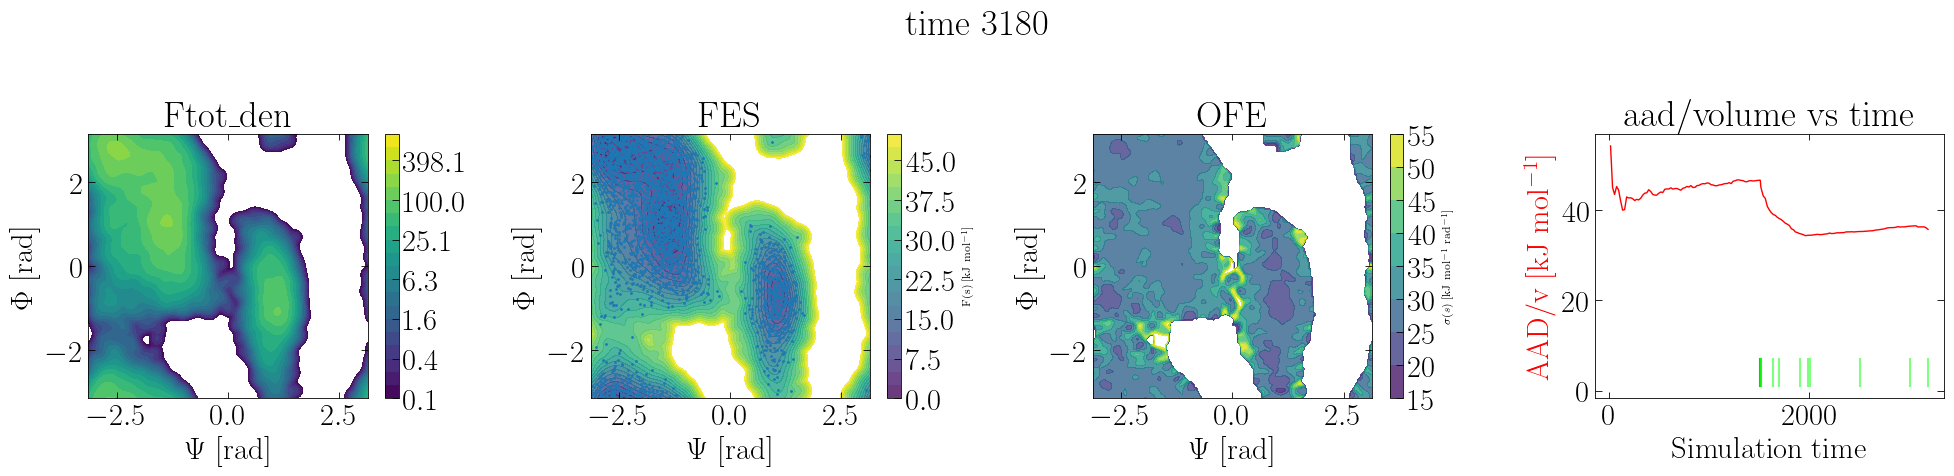

|************************************************  | 96% | Average Mean Force Error: 30.092

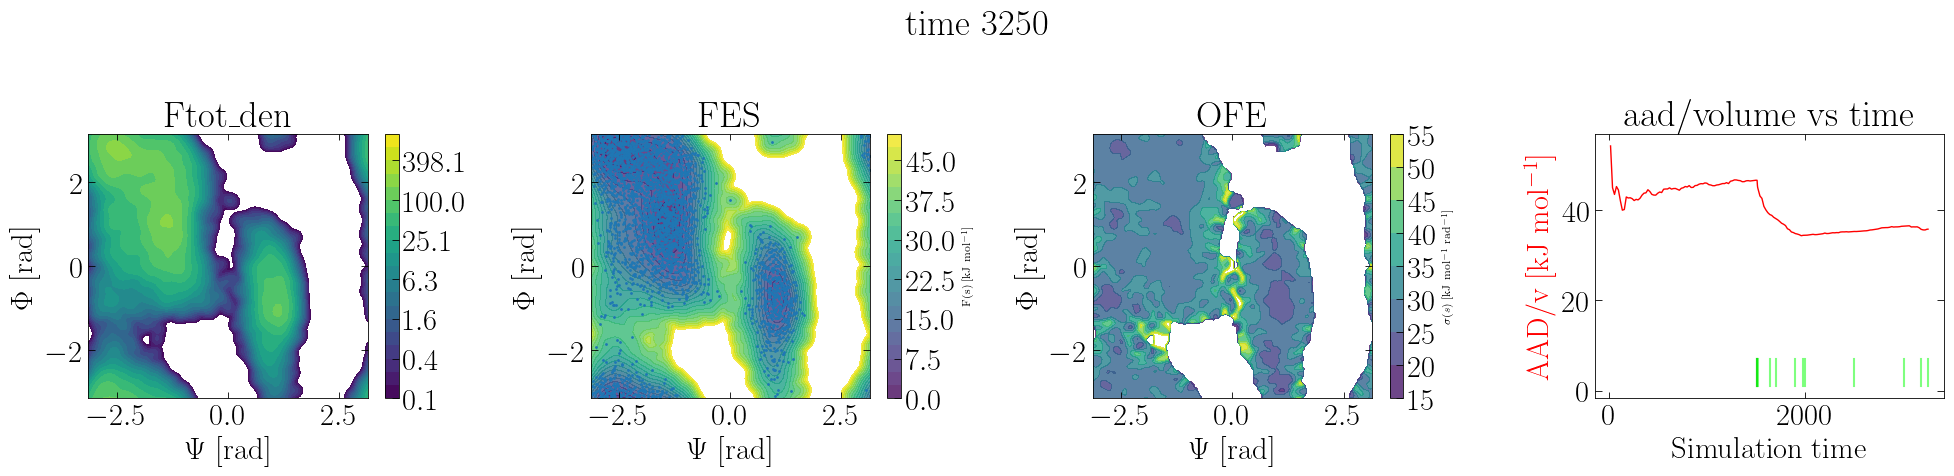

|**************************************************| 99% | Average Mean Force Error: 30.192

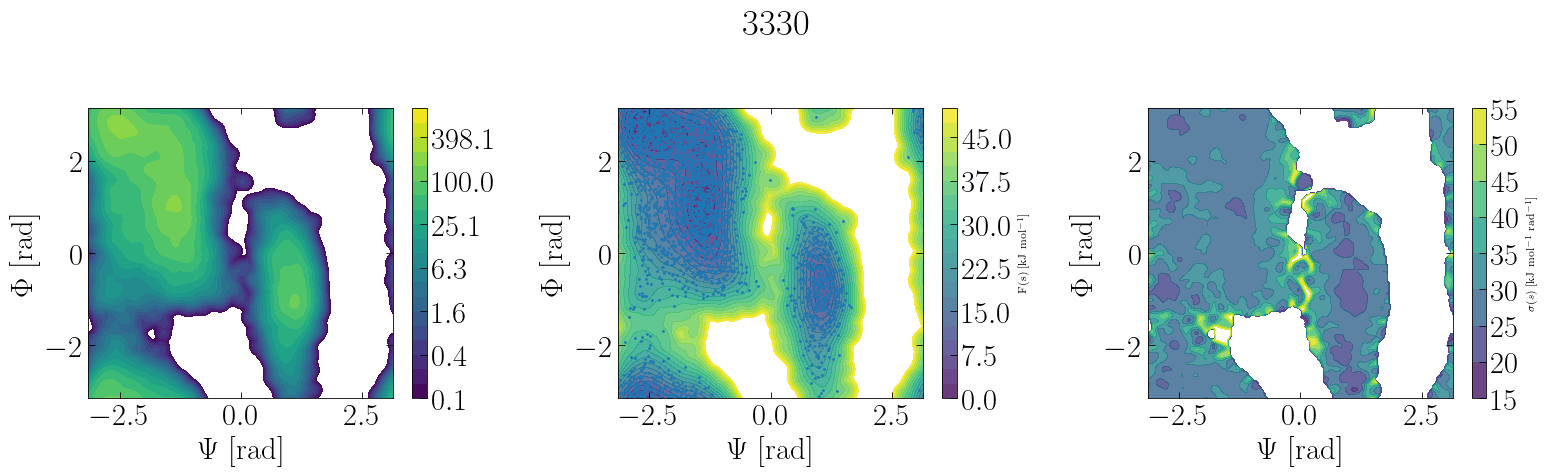

In [19]:
NH=3330
from matplotlib.colors import LogNorm

hills_list = [1511,1512,1514,1516, 1640, 1700, 1900, 1980, 2000, 2500, 3000, 3180, 3250]

results = MFI_2D_plot(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace=int(10000/500), WellTempered=1, nhills=NH, periodic = np.array((1,1)), hills_list=hills_list)
[X, Y, Ftot_den_temp, Ftot_x_temp, Ftot_y_temp, ofv_temp, ofe_temp, cutoff_temp, volume_history_temp,  ofe_history_temp, aad_history_temp, time_history_temp, Ftot_den2_temp, ofv_num_x_temp, ofv_num_y_temp, all_ofe_temp, all_aad_temp] = results

[X, Y, FES_temp] = MFI.FFT_intg_2D(Ftot_x_temp, Ftot_y_temp, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
levels = np.logspace(np.log10(0.1), np.log10(1000), 21)
cp = axs[0].contourf(X, Y, np.where(Ftot_den_temp > 0, Ftot_den_temp, np.nan), levels=levels, norm=LogNorm(), cmap='viridis')#, antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0]); axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y)); 

cp = axs[1].contourf(X, Y, FES_temp, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=8); axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y)); 
axs[1].scatter(HILLS[:NH,1],HILLS[:NH,2],s=1)

cp = axs[2].contourf(X, Y, ofe_temp*cutoff_temp, levels=np.arange(15, 60, 5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2]); cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=8); axs[2].set_ylabel('$\Phi$ [rad]'); axs[2].set_xlabel('$\Psi$ [rad]')
axs[2].set_xlim(np.min(X),np.max(X)); axs[2].set_ylim(np.min(Y),np.max(Y))

plt.suptitle(str(NH)); fig.tight_layout(); plt.show()

(200, 200)
|**************************************************| 100% | Average Mean Force Error: 30.124

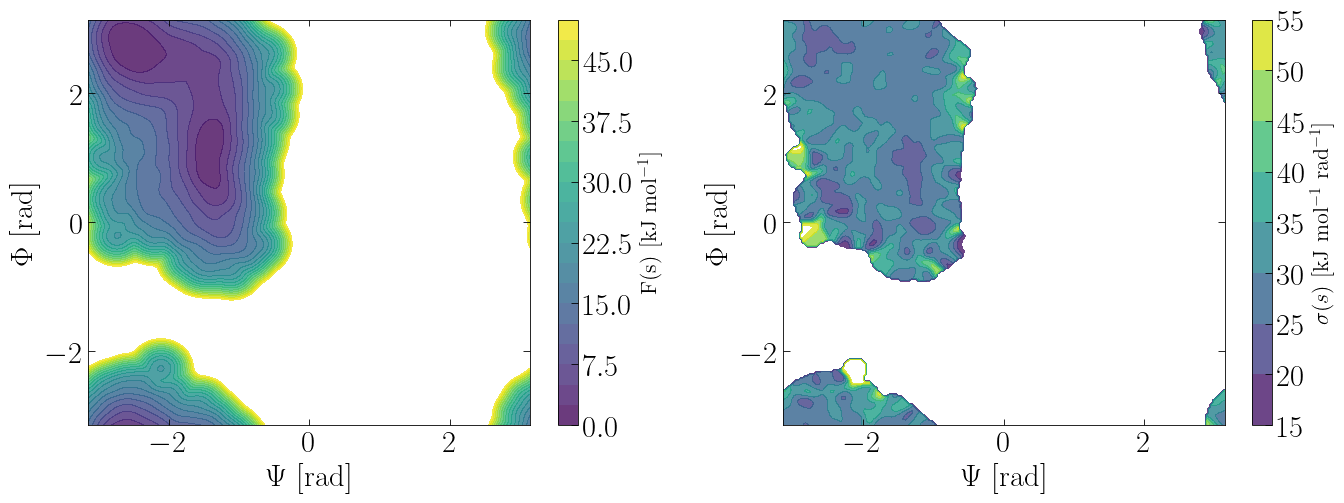

In [27]:
NH=500

# #Compute the time-independent mean force
results2 = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace = 10, WellTempered=1, nhills=NH, periodic = np.array((1,1)))
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results2

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe*cutoff, levels=np.arange(15, 60, 5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()   



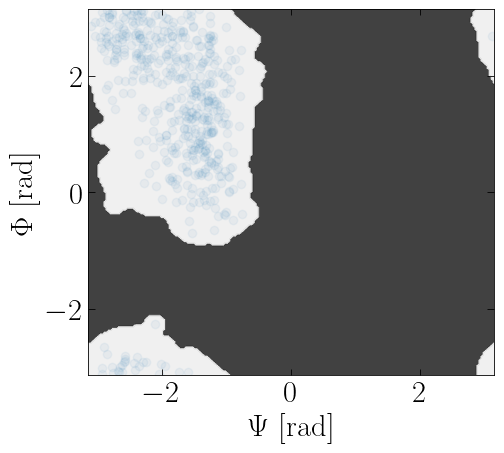

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()


# plt.savefig('Figure1B_4', dpi=600, bbox_inches='tight')

(200, 200)
|**************************************************| 100% | Average Mean Force Error: 30.713

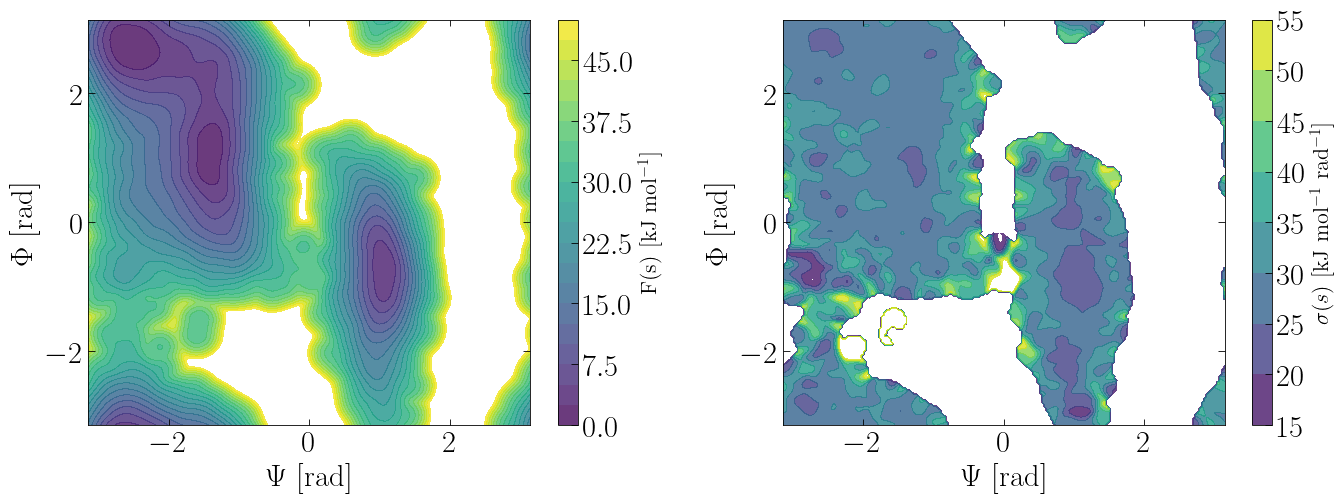

In [31]:
NH=2000

##Compute the time-independent mean force
results3 = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace = 100, WellTempered=1, nhills=NH, periodic = np.array((1,1)))
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results3

##integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe*cutoff, levels=np.arange(15, 60, 5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()  

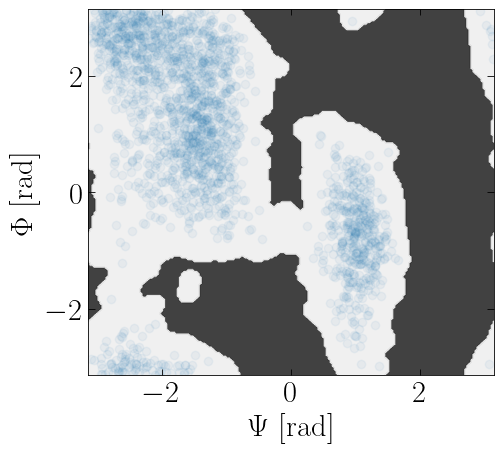

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()


# plt.savefig('Figure1B_5', dpi=600, bbox_inches='tight')